In [19]:
from retsupp.utils.data import Subject, get_subject_ids
from nilearn import image, plotting
import seaborn as sns
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

In [2]:
bids_folder = Path('/data/ds-retsupp')

def get_conditionwise_pars(subject, bids_folder=bids_folder):
    par_labels = ['x', 'y', 'sd', 'amplitude', 'ecc', 'r2', 'srf_size', 'srf_amplitude', 'hrf_delay', 'hrf_dispersion']
    subject = int(subject)
    condition_pars = pd.read_csv(bids_folder / 'derivatives/prf_summaries.conditionwise/model4/sub-{subject:02d}/sub-{subject:02d}_model-4_prf_voxels.tsv'.format(subject=subject), sep='\t', index_col=[0, 1, 2])

    condition_mean_pars = condition_pars.groupby(['roi', 'voxel']).mean()
    condition_pars = condition_pars.join(condition_mean_pars[par_labels], rsuffix='_mean')

    condition_pars.reset_index(inplace=True)
    condition_pars['roi'] = condition_pars['roi'].str.replace('_L', '').str.replace('_R', '')
    condition_pars.set_index(['roi', 'voxel', 'condition'], inplace=True)

    # condition_pars['x_coordinate_distractor'] = condition_pars['distractor_location'].apply(lambda loc: get_distractor_coords(loc, radius=4)[0])
    # condition_pars['y_coordinate_distractor'] = condition_pars['distractor_location'].apply(lambda loc: get_distractor_coords(loc, radius=4)[1])

    # condition_pars['distance_to_distractor'] = np.sqrt((condition_pars['x'] - condition_pars['x_coordinate_distractor'])**2 + (condition_pars['y'] - condition_pars['y_coordinate_distractor'])**2)

    for par in par_labels:
        condition_pars[par + '_diff'] = condition_pars[par] - condition_pars[par + '_mean']  
    
    return condition_pars

# --- Helper function to get distractor coordinates ---
def get_distractor_coords(label, radius=4.):
    mapping = {
        'upper right': np.pi/4,
        'upper left': 3*np.pi/4,
        'lower left': 5*np.pi/4,
        'lower right': 7*np.pi/4
    }
    angle = mapping.get(label, None)
    if angle is None:
        return None, None
    x = radius * np.cos(angle)
    y = radius * np.sin(angle)
    return x, y

In [21]:
pars = []
subjects = get_subject_ids()

keys = []
for subject in subjects:
    try:
        pars.append(get_conditionwise_pars(subject))
        keys.append(subject)
        print(f'Processing subject {subject}')
    except FileNotFoundError:
        print(f'No data for subject {subject}, skipping.')

pars = pd.concat(pars, keys=keys, names=['subject'])
pars['distractor_location'] = pars.index.get_level_values('condition').str.replace('_', ' ')
pars = pars[pars['r2'] > 0.0]

roi_order = ['V1', 'V2', 'V3', 'hV4', 'LO1', 'LO2', 'V3A', 'V3B', 'TO1','TO2']

Processing subject 01
Processing subject 02
Processing subject 03
Processing subject 04
Processing subject 05
Processing subject 06
Processing subject 07
Processing subject 08
Processing subject 09
Processing subject 10
Processing subject 11
Processing subject 12
Processing subject 13
Processing subject 14
Processing subject 15
Processing subject 16
Processing subject 17
Processing subject 18
Processing subject 19
Processing subject 20
Processing subject 21
Processing subject 22
Processing subject 23
Processing subject 24
Processing subject 25
Processing subject 26
Processing subject 27
Processing subject 28
Processing subject 29
Processing subject 30


R² threshold: 0.05


/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_3555/2310543474.py:71: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = binned.groupby(['subject', 'x_bin', 'y_bin']).apply(


TypeError: agg function failed [how->mean,dtype->object]

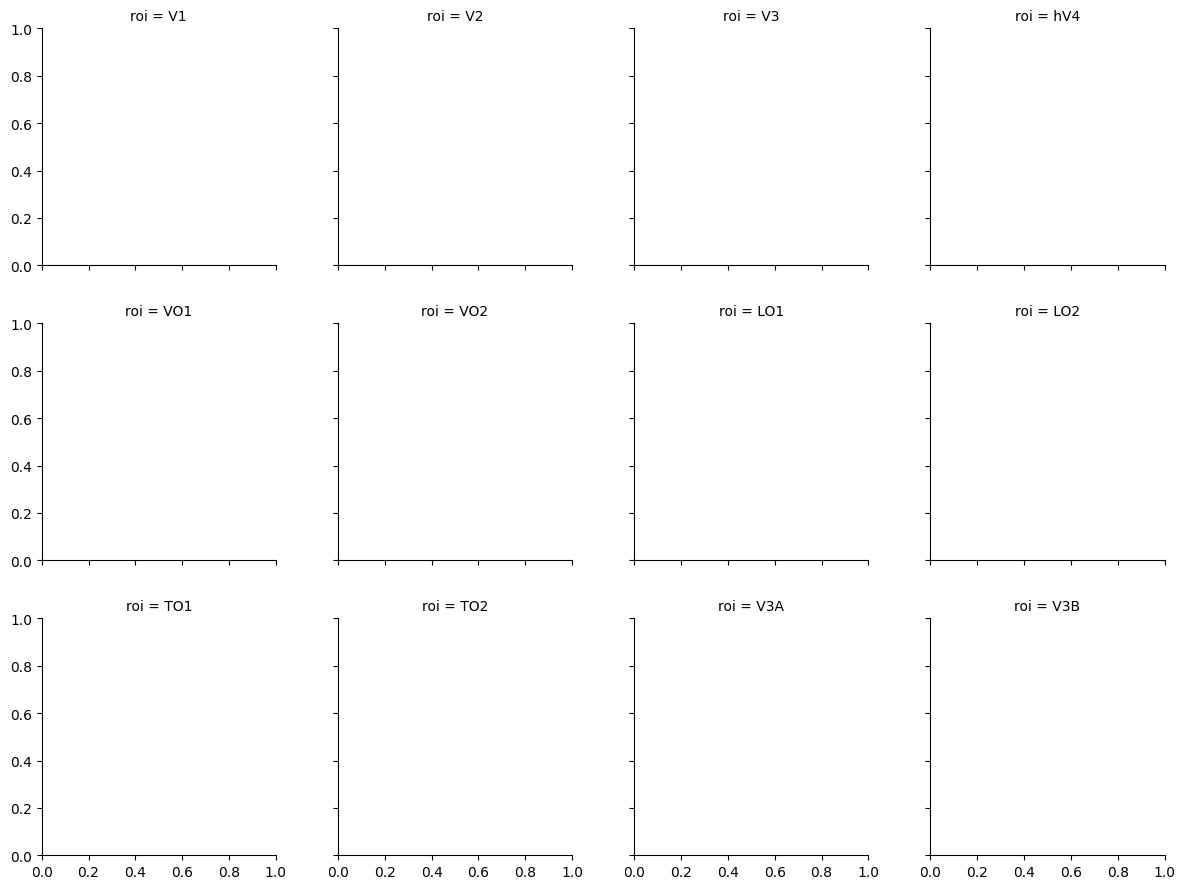

In [22]:
import numpy as np

def rotate_x_y(x, y, angle):
    """Rotate coordinates (x, y) by angle (in radians)"""
    x = np.asarray(x)
    y = np.asarray(y)
    angle = np.asarray(angle)
    x_rot = x * np.cos(angle) - y * np.sin(angle)
    y_rot = x * np.sin(angle) + y * np.cos(angle)
    return x_rot, y_rot

location_angles = {
    'upper right': np.pi/4,
    'upper left': 3*np.pi/4,
    'lower left': 5*np.pi/4,
    'lower right': 7*np.pi/4
}
# Map distractor location to rotation angle (to bring to top)
rotate_to_up = {loc: (np.pi/2 - angle) for loc, angle in location_angles.items()}

data = pars.copy()

# Vectorized rotation for speed
angles = data['distractor_location'].map(rotate_to_up).fillna(0).values

x_mean_rot, y_mean_rot = rotate_x_y(data['x_mean'].values, data['y_mean'].values, angles)
x_diff_rot, y_diff_rot = rotate_x_y(data['x_diff'].values, data['y_diff'].values, angles)
x_rot, y_rot = rotate_x_y(data['x'].values, data['y'].values, angles)

data['x_mean_rotated'] = x_mean_rot
data['y_mean_rotated'] = y_mean_rot
# data['x_diff_rotated'] = x_diff_rot
# data['y_diff_rotated'] = y_diff_rot
data['x_rotated'] = x_rot
data['y_rotated'] = y_rot

data['x_diff_rotated'] = data['x_rotated'] - data['x_mean_rotated']
data['y_diff_rotated'] = data['y_rotated'] - data['y_mean_rotated']

data['x_diff_rotated2'] = x_diff_rot
data['y_diff_rotated2'] = y_diff_rot

data['distance_to_distractor_mean'] = np.sqrt(
    (data['x_mean_rotated'] - 0) ** 2 + (data['y_mean_rotated'] - 4) ** 2)

data['distance_to_distractor'] = np.sqrt(
    (data['x_rotated'] - 0) ** 2 + (data['y_rotated'] - 4) ** 2)

data['distance_to_distractor_diff'] = data['distance_to_distractor'] - data['distance_to_distractor_mean']

def plot_binned_vector_field_with_distractor(data, bins=5, scale=.1, **kwargs):
    # Get distractor label for this facet
    # Bin x_mean and y_mean
    x = data['x_mean_rotated']
    y = data['y_mean_rotated']
    u = data['x_diff_rotated']
    v = data['y_diff_rotated']
    x_edges = np.linspace(-3.25, 3.25, bins+1)
    y_edges = np.linspace(-3.25, 3.25, bins+1)
    x_bin = np.digitize(x, x_edges) - 1
    y_bin = np.digitize(y, y_edges) - 1
    binned = data.copy()
    binned['x_bin'] = x_bin
    binned['y_bin'] = y_bin
    # grouped = binned.groupby(['x_bin','y_bin']).agg({
    #     'x_mean_rotated':'median',
    #     'y_mean_rotated':'median',
    #     'x_diff_rotated':'median',
    #     'y_diff_rotated':'median'
    # }).reset_index()
    grouped = binned.groupby(['subject', 'x_bin', 'y_bin']).apply(
        lambda df: pd.Series({
            'x_mean_rotated': np.average(df['x_mean_rotated'], weights=df['r2']),
            'y_mean_rotated': np.average(df['y_mean_rotated'], weights=df['r2']),
            'x_diff_rotated': np.average(df['x_diff_rotated2'], weights=df['r2']),
            'y_diff_rotated': np.average(df['y_diff_rotated2'], weights=df['r2']),
        })
    ).reset_index()

    grouped = grouped.groupby(['x_bin','y_bin']).mean().reset_index()

    mask = (grouped['x_bin']>=0) & (grouped['x_bin']<bins) & (grouped['y_bin']>=0) & (grouped['y_bin']<bins)
    grouped = grouped[mask]
    plt.quiver(grouped['x_mean_rotated'], grouped['y_mean_rotated'], grouped['x_diff_rotated'], grouped['y_diff_rotated'], angles='xy', scale_units='xy', scale=scale, color='black', alpha=0.8)
    plt.xlim(-3.25, 3.25)
    plt.ylim(-3.25,3.25)
    plt.gca().set_aspect('equal', adjustable='box')
    sns.despine()

    plt.plot(0.0, 3., 'ro', markersize=12, label='Distractor')   

for r2_thr in [0.05, 0.1, 0.2][:]:
    print(f'R² threshold: {r2_thr}')
    g = sns.FacetGrid(data[data['r2_mean'] > r2_thr].query('ecc_mean < 2.5').reset_index(), col='roi', row_order=roi_order, col_wrap=4)
    g.map_dataframe(plot_binned_vector_field_with_distractor, bins=8, scale=None)


R² threshold: 0.4


/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_3555/1311040475.py:74: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = binned.groupby(['subject', 'x_bin', 'y_bin']).apply(
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_3555/1311040475.py:74: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = binned.groupby(['subject', 'x_bin', 'y_bin']).apply(
/var/folders/d4/cpqhwlbn301clph1qk64k0

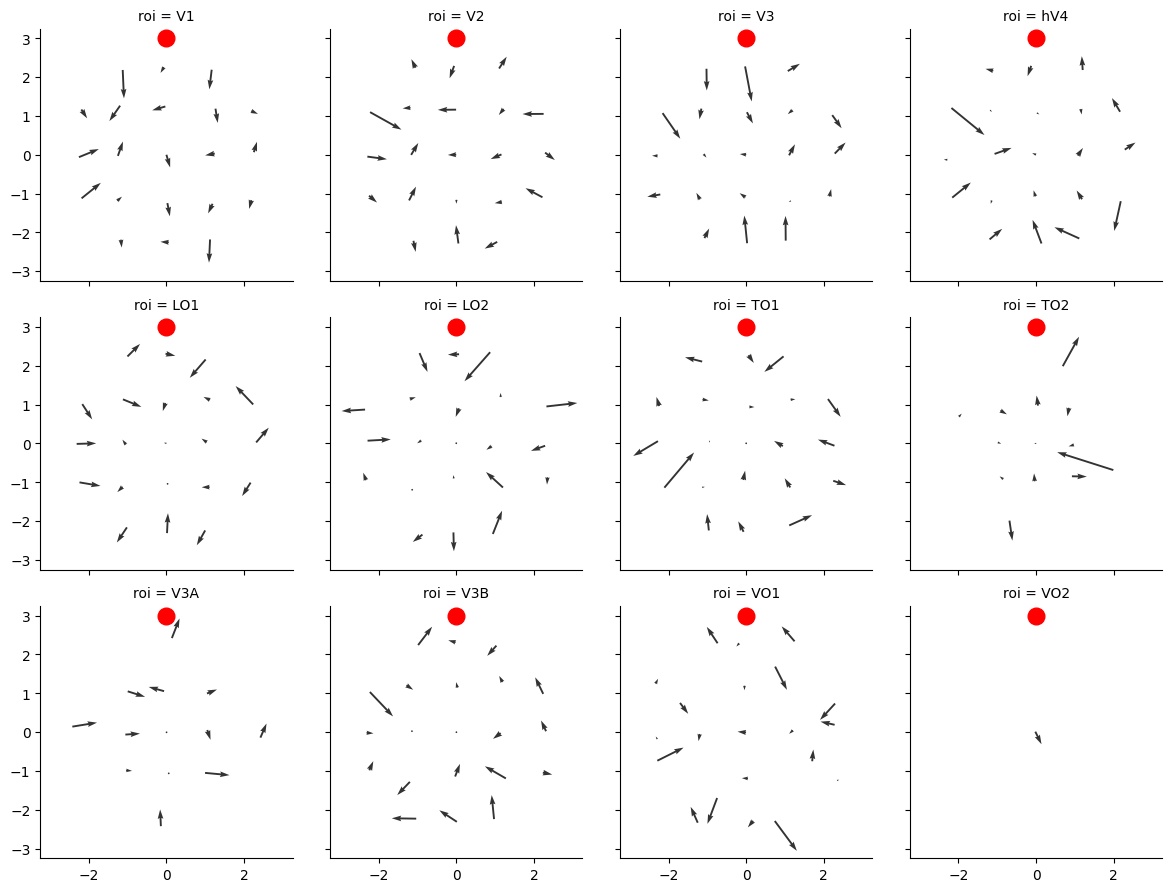

In [ ]:
import numpy as np

def rotate_x_y(x, y, angle):
    """Rotate coordinates (x, y) by angle (in radians)"""
    x = np.asarray(x)
    y = np.asarray(y)
    angle = np.asarray(angle)
    x_rot = x * np.cos(angle) - y * np.sin(angle)
    y_rot = x * np.sin(angle) + y * np.cos(angle)
    return x_rot, y_rot

location_angles = {
    'upper right': np.pi/4,
    'upper left': 3*np.pi/4,
    'lower left': 5*np.pi/4,
    'lower right': 7*np.pi/4
}
# Map distractor location to rotation angle (to bring to top)
rotate_to_up = {loc: (np.pi/2 - angle) for loc, angle in location_angles.items()}

data = pars.copy()

# Vectorized rotation for speed
angles = data['distractor_location'].map(rotate_to_up).fillna(0).values

x_mean_rot, y_mean_rot = rotate_x_y(data['x_mean'].values, data['y_mean'].values, angles)
x_diff_rot, y_diff_rot = rotate_x_y(data['x_diff'].values, data['y_diff'].values, angles)
x_rot, y_rot = rotate_x_y(data['x'].values, data['y'].values, angles)

data['x_mean_rotated'] = x_mean_rot
data['y_mean_rotated'] = y_mean_rot
# data['x_diff_rotated'] = x_diff_rot
# data['y_diff_rotated'] = y_diff_rot
data['x_rotated'] = x_rot
data['y_rotated'] = y_rot

data['x_diff_rotated'] = data['x_rotated'] - data['x_mean_rotated']
data['y_diff_rotated'] = data['y_rotated'] - data['y_mean_rotated']

data['x_diff_rotated2'] = x_diff_rot
data['y_diff_rotated2'] = y_diff_rot

data['x_diff_rotated_norm'] = data['x_diff_rotated'] / data['sd']
data['y_diff_rotated_norm'] = data['y_diff_rotated'] / data['sd']

data['distance_to_distractor_mean'] = np.sqrt(
    (data['x_mean_rotated'] - 0) ** 2 + (data['y_mean_rotated'] - 4) ** 2)

data['distance_to_distractor'] = np.sqrt(
    (data['x_rotated'] - 0) ** 2 + (data['y_rotated'] - 4) ** 2)

data['distance_to_distractor_diff'] = data['distance_to_distractor'] - data['distance_to_distractor_mean']

def plot_binned_vector_field_with_distractor(data, bins=5, scale=.1, **kwargs):
    # Get distractor label for this facet
    # Bin x_mean and y_mean
    x = data['x_mean_rotated']
    y = data['y_mean_rotated']
    u = data['x_diff_rotated']
    v = data['y_diff_rotated']
    x_edges = np.linspace(-3.25, 3.25, bins+1)
    y_edges = np.linspace(-3.25, 3.25, bins+1)
    x_bin = np.digitize(x, x_edges) - 1
    y_bin = np.digitize(y, y_edges) - 1
    binned = data.copy()
    binned['x_bin'] = x_bin
    binned['y_bin'] = y_bin
    # grouped = binned.groupby(['x_bin','y_bin']).agg({
    #     'x_mean_rotated':'median',
    #     'y_mean_rotated':'median',
    #     'x_diff_rotated':'median',
    #     'y_diff_rotated':'median'
    # }).reset_index()
    grouped = binned.groupby(['subject', 'x_bin', 'y_bin']).apply(
        lambda df: pd.Series({
            'x_mean_rotated': np.average(df['x_mean_rotated'], weights=df['r2']),
            'y_mean_rotated': np.average(df['y_mean_rotated'], weights=df['r2']),
            'x_diff_rotated_norm': np.average(df['x_diff_rotated_norm'], weights=df['r2']),
            'y_diff_rotated_norm': np.average(df['y_diff_rotated_norm'], weights=df['r2']),
        })
    ).reset_index()

    grouped = grouped.groupby(['x_bin','y_bin']).mean().reset_index()

    mask = (grouped['x_bin']>=0) & (grouped['x_bin']<bins) & (grouped['y_bin']>=0) & (grouped['y_bin']<bins)
    grouped = grouped[mask]
    plt.quiver(grouped['x_mean_rotated'], grouped['y_mean_rotated'], grouped['x_diff_rotated_norm'], grouped['y_diff_rotated_norm'], angles='xy', scale_units='xy', scale=scale, color='black', alpha=0.8)
    plt.xlim(-3.25, 3.25)
    plt.ylim(-3.25,3.25)
    plt.gca().set_aspect('equal', adjustable='box')
    sns.despine()

    plt.plot(0.0, 3., 'ro', markersize=12, label='Distractor')   

for r2_thr in [0.05, 0.1, 0.4][-1:]:
    print(f'R² threshold: {r2_thr}')
    g = sns.FacetGrid(data[data['r2_mean'] > r2_thr].query('ecc_mean < 2.75').reset_index(), col='roi', row_order=roi_order, col_wrap=4)
    g.map_dataframe(plot_binned_vector_field_with_distractor, bins=5, scale=None)


(-2.0, 2.0)

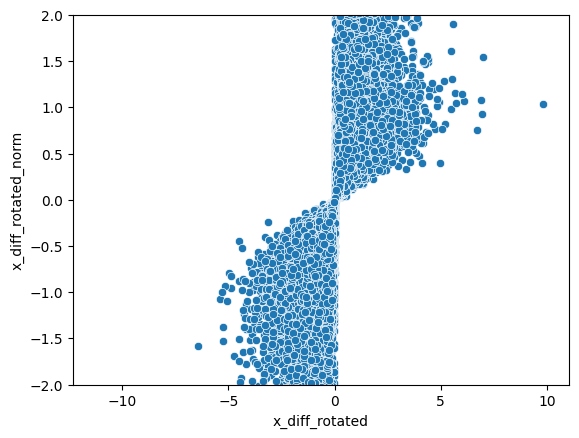

In [ ]:
sns.scatterplot(x='x_diff_rotated', y='x_diff_rotated_norm', data=data[data.r2 > 0.1][['x_diff_rotated_norm', 'x_diff_rotated']])
plt.ylim(-2, 2)

In [ ]:
data

x         y        sd  amplitude  \
subject roi voxel condition                                              
1       V1  35    lower_left  -2.552935  0.390998  1.649876  58.247390   
            36    lower_left  -2.347467 -1.165123  2.733238  37.337936   
            37    lower_left  -0.911355 -0.469936  0.993881  38.370420   
            38    lower_left  -0.401807 -0.086713  1.173315  50.781425   
            51    lower_left   2.261638  1.356916  0.008947  66.102430   
...                                 ...       ...       ...        ...   
29      V3B 417   upper_right -1.207483  1.359428  0.621483  19.162722   
            419   upper_right -1.062892 -0.086297  1.238283  17.173714   
            425   upper_right -0.158604  0.193109  0.336396  16.642560   
            428   upper_right -1.353287 -0.527725  1.044452  11.462991   
            436   upper_right -0.175730  0.271461  0.159346  32.511127   

                               baseline        r2     theta       ecc  \
subject roi voxel condition                                             
1       V1  35    lower_left  -0.485119  0.150759  2.989618  2.582703   
            36    lower_left  -0.069423  0.064793 -2.680884  2.620709   
            37    lower_left  -0.017081  0.164769 -2.665508  1.025382   
            38    lower_left  -0.120132  0.208748 -2.929044  0.411057   
            51    lower_left  -0.038287  0.027684  0.540398  2.637466   
...                                 ...       ...       ...       ...   
29      V3B 417   upper_right -0.012226  0.049414  2.297070  1.818258   
            419   upper_right -0.016521  0.061768 -3.060579  1.066389   
            425   upper_right  0.011911  0.111169  2.258401  0.249893   
            428   upper_right -0.086187  0.084177 -2.769773  1.452542   
            436   upper_right  0.001607  0.063566  2.145306  0.323376   

                                srf_size  srf_amplitude  ...  y_rotated  \
subject roi voxel condition                              ...              
1       V1  35    lower_left   25.808470       0.032961  ...   1.528721   
            36    lower_left   20.862709       0.441919  ...   2.483776   
            37    lower_left   17.116787       0.186306  ...   0.976720   
            38    lower_left   26.404612       0.220187  ...   0.345436   
            51    lower_left   17.958176       0.085486  ...  -2.558704   
...                                  ...            ...  ...        ...   
29      V3B 417   upper_right   1.757103       0.350816  ...   0.107442   
            419   upper_right   1.552539       0.512461  ...  -0.812599   
            425   upper_right  15.877730       0.027865  ...   0.024399   
            428   upper_right  24.111920       0.083025  ...  -1.330076   
            436   upper_right   4.322255       0.053521  ...   0.067692   

                               x_diff_rotated  y_diff_rotated  \
subject roi voxel condition                                     
1       V1  35    lower_left         1.351904        0.980033   
            36    lower_left        -0.040389        1.224608   
            37    lower_left         0.408309        0.123611   
            38    lower_left        -0.219468       -0.041960   
            51    lower_left         0.032872       -0.015663   
...                                       ...             ...   
29      V3B 417   upper_right       -0.381735        0.504062   
            419   upper_right       -0.578746       -0.882803   
            425   upper_right       -0.180384       -0.042185   
            428   upper_right        0.564490       -1.480030   
            436   upper_right       -0.249141       -0.340327   

                               x_diff_rotated2  y_diff_rotated2  \
subject roi voxel condition                                       
1       V1  35    lower_left          1.351904         0.980033   
            36    lower_left         -0.040389         1.224608   
            37    lower_left       

In [ ]:
data['x_diff_rotated'].mean()

-0.003871719760509972

In [ ]:
data['y_diff_rotated'].mean()

0.008243408447044982

<Axes: xlabel='x_diff_rotated', ylabel='Count'>

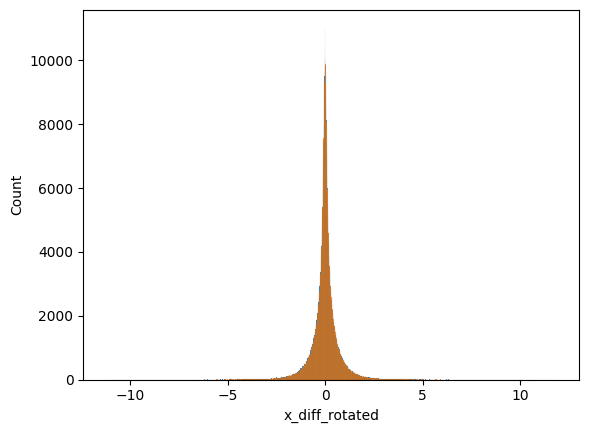

In [ ]:
sns.histplot(data['x_diff_rotated'])
sns.histplot(data['y_diff_rotated'])

In [ ]:
data

x         y        sd  amplitude  \
subject roi voxel condition                                              
1       V1  35    lower_left  -2.552935  0.390998  1.649876  58.247390   
            36    lower_left  -2.347467 -1.165123  2.733238  37.337936   
            37    lower_left  -0.911355 -0.469936  0.993881  38.370420   
            38    lower_left  -0.401807 -0.086713  1.173315  50.781425   
            51    lower_left   2.261638  1.356916  0.008947  66.102430   
...                                 ...       ...       ...        ...   
29      V3B 417   upper_right -1.207483  1.359428  0.621483  19.162722   
            419   upper_right -1.062892 -0.086297  1.238283  17.173714   
            425   upper_right -0.158604  0.193109  0.336396  16.642560   
            428   upper_right -1.353287 -0.527725  1.044452  11.462991   
            436   upper_right -0.175730  0.271461  0.159346  32.511127   

                               baseline        r2     theta       ecc  \
subject roi voxel condition                                             
1       V1  35    lower_left  -0.485119  0.150759  2.989618  2.582703   
            36    lower_left  -0.069423  0.064793 -2.680884  2.620709   
            37    lower_left  -0.017081  0.164769 -2.665508  1.025382   
            38    lower_left  -0.120132  0.208748 -2.929044  0.411057   
            51    lower_left  -0.038287  0.027684  0.540398  2.637466   
...                                 ...       ...       ...       ...   
29      V3B 417   upper_right -0.012226  0.049414  2.297070  1.818258   
            419   upper_right -0.016521  0.061768 -3.060579  1.066389   
            425   upper_right  0.011911  0.111169  2.258401  0.249893   
            428   upper_right -0.086187  0.084177 -2.769773  1.452542   
            436   upper_right  0.001607  0.063566  2.145306  0.323376   

                                srf_size  srf_amplitude  ...  y_mean_rotated  \
subject roi voxel condition                              ...                   
1       V1  35    lower_left   25.808470       0.032961  ...        0.548687   
            36    lower_left   20.862709       0.441919  ...        1.259168   
            37    lower_left   17.116787       0.186306  ...        0.853109   
            38    lower_left   26.404612       0.220187  ...        0.387396   
            51    lower_left   17.958176       0.085486  ...       -2.543041   
...                                  ...            ...  ...             ...   
29      V3B 417   upper_right   1.757103       0.350816  ...       -0.396620   
            419   upper_right   1.552539       0.512461  ...        0.070203   
            425   upper_right  15.877730       0.027865  ...        0.066584   
            428   upper_right  24.111920       0.083025  ...        0.149954   
            436   upper_right   4.322255       0.053521  ...        0.408019   

                               x_rotated  y_rotated  x_diff_rotated  \
subject roi voxel condition                                           
1       V1  35    lower_left    2.081675   1.528721        1.351904   
            36    lower_left    0.836044   2.483776       -0.040389   
            37    lower_left    0.312131   0.976720        0.408309   
            38    lower_left    0.222805   0.345436       -0.219468   
            51    lower_left   -0.639735  -2.558704        0.032872   
...                                  ...        ...             ...   
29      V3B 417   upper_right  -1.815080   0.107442       -0.381735   
            419   upper_right  -0.690556  -0.812599       -0.578746   
            425   upper_right  -0.248699   0.024399       -0.180384   
            428   upper_right  -0.583760  -1.330076        0.564490   
            436   upper_right  -0.316212   0.067692       -0.249141   

                               y_diff_rotated  x_diff_rotated2  \
subject roi voxel condition                                      
1       V1  35    lower_left

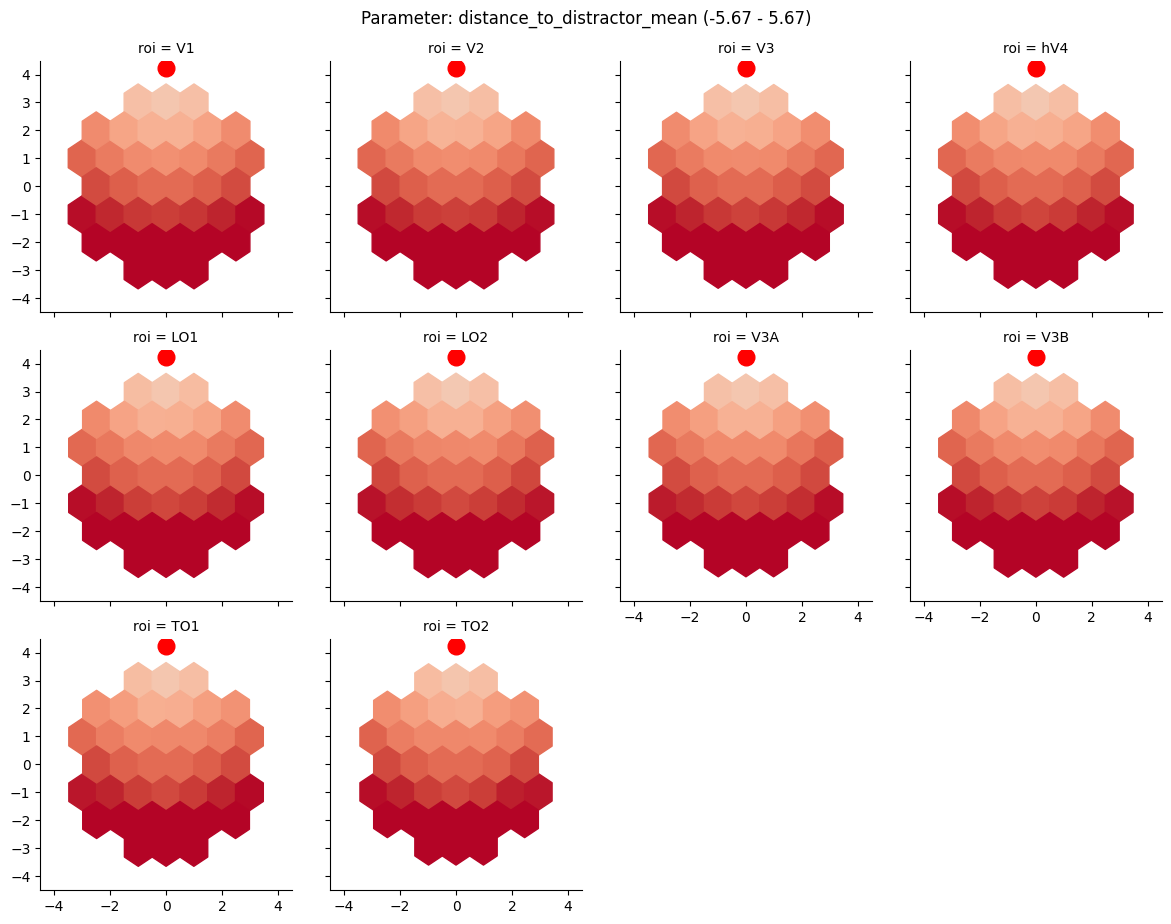

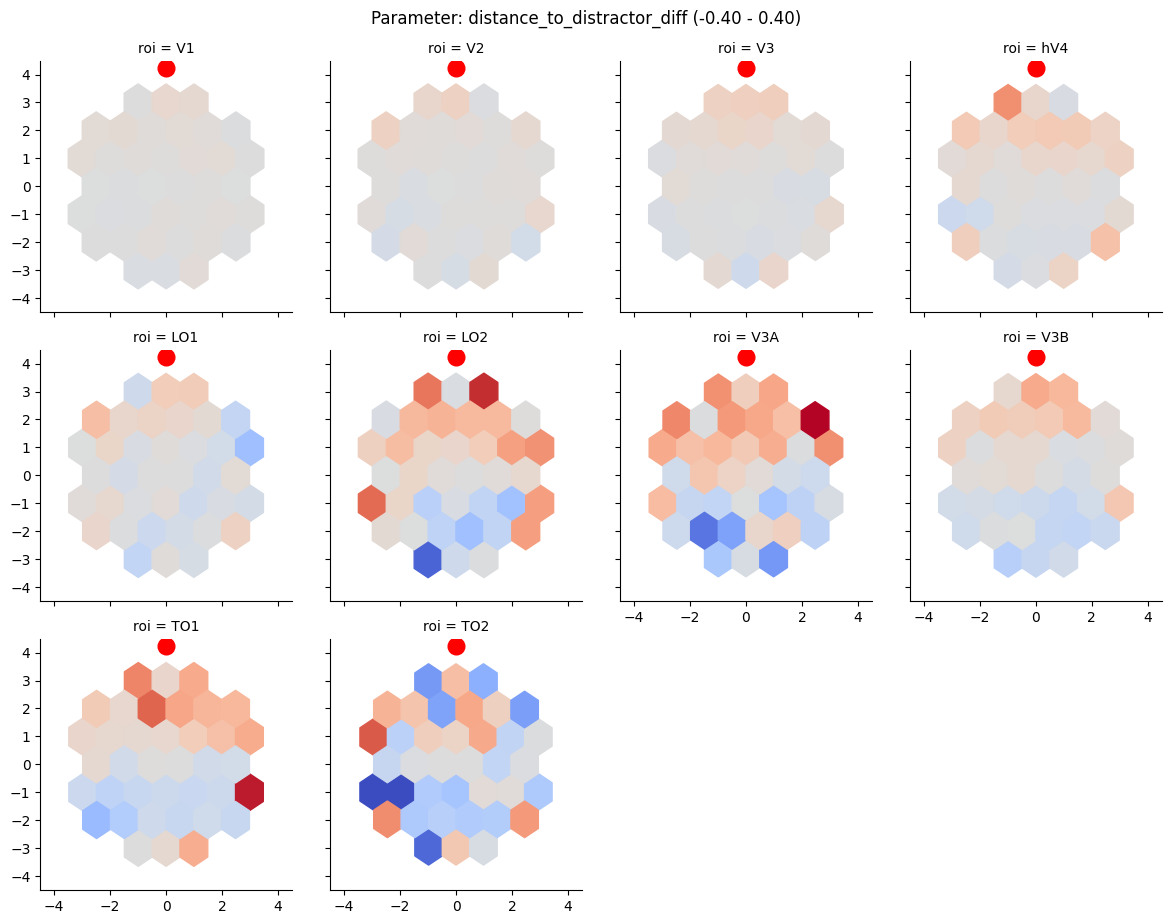

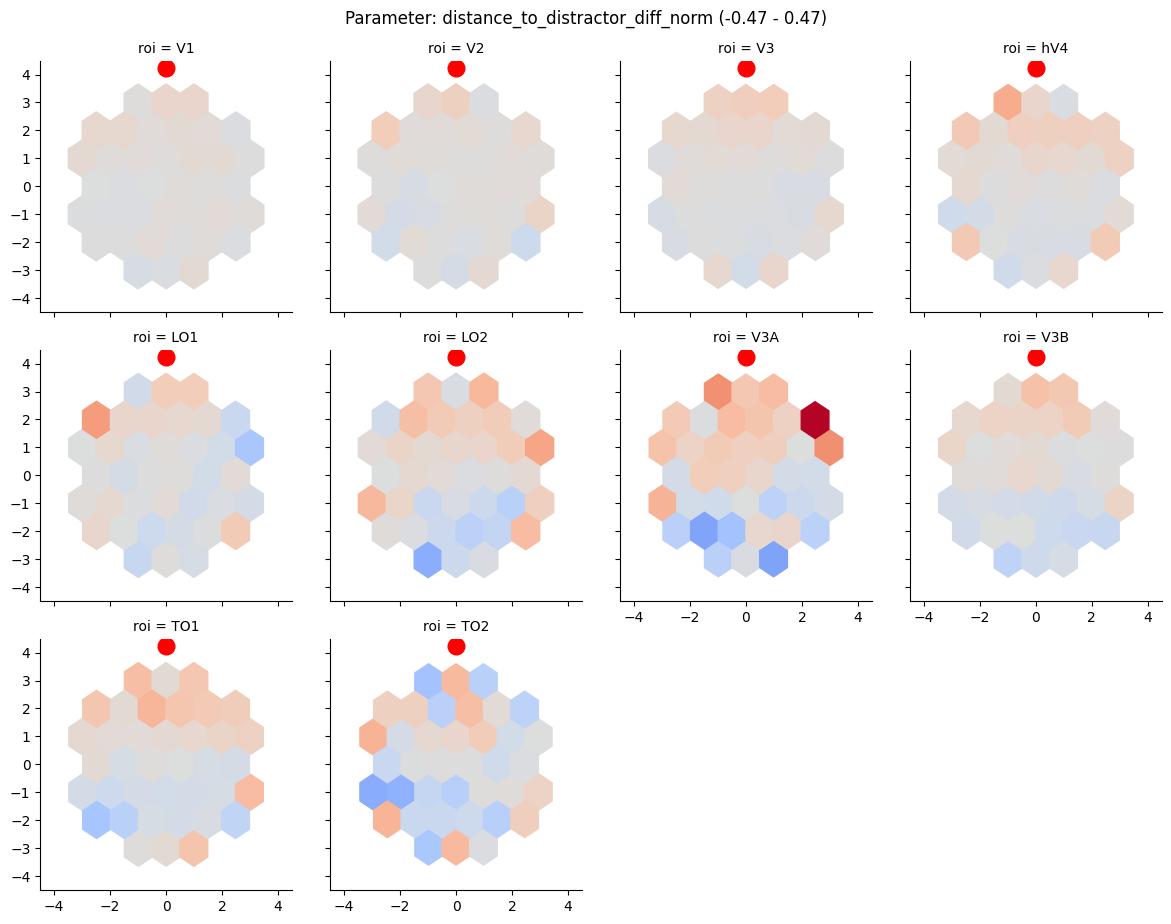

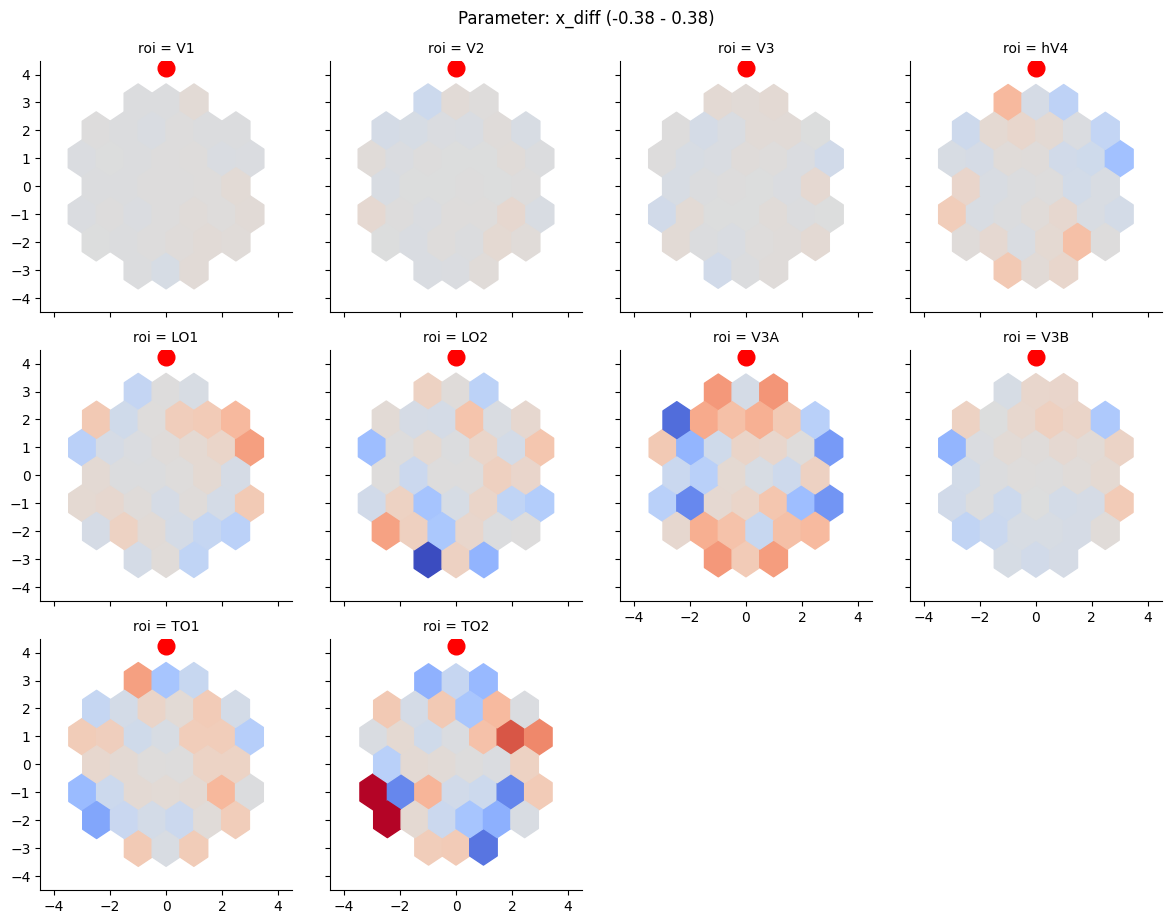

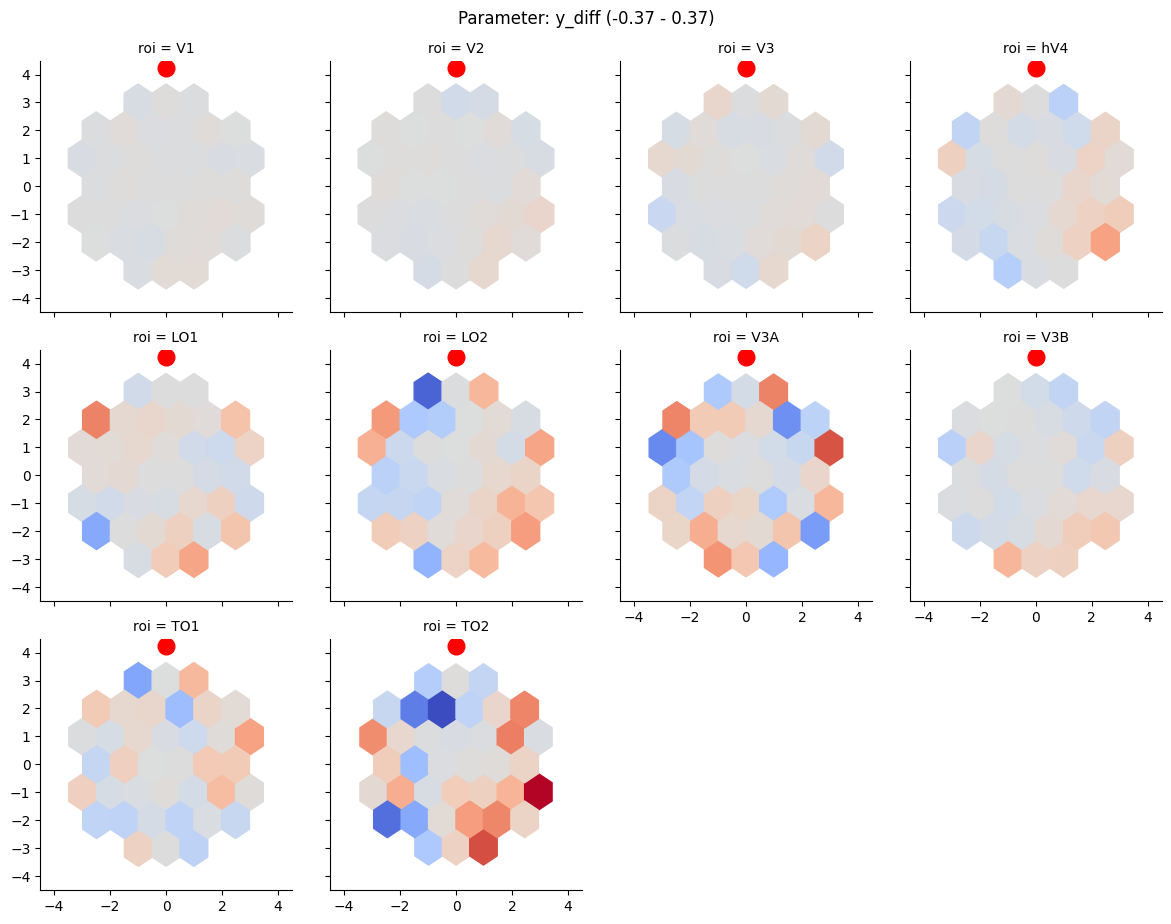

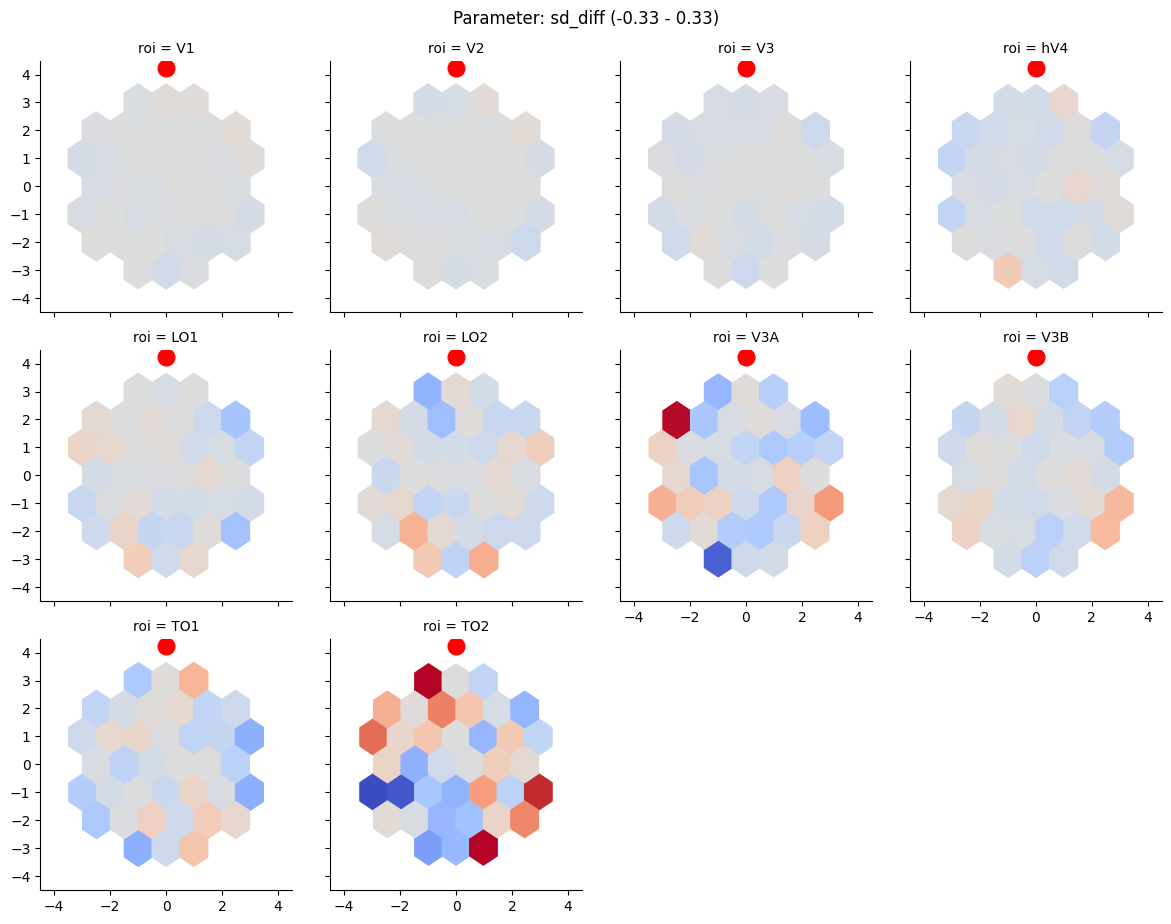

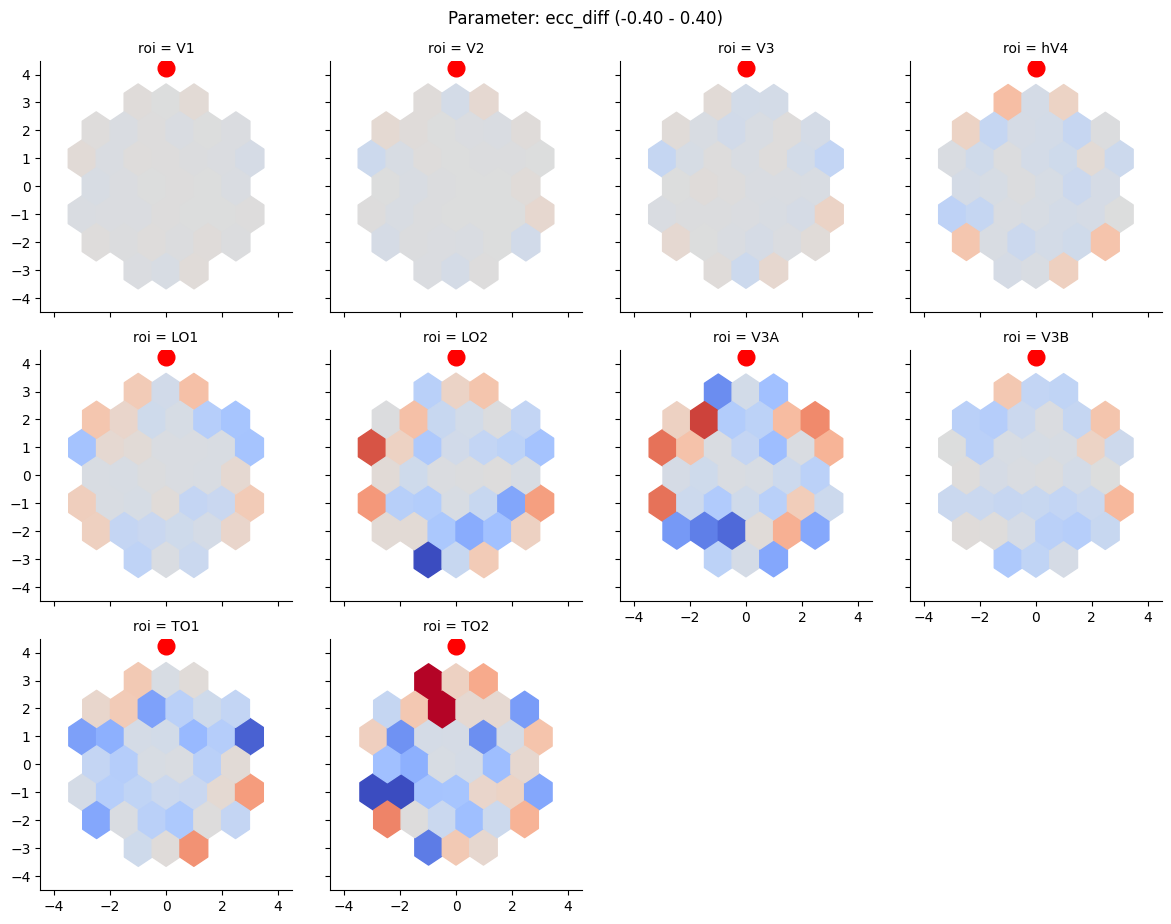

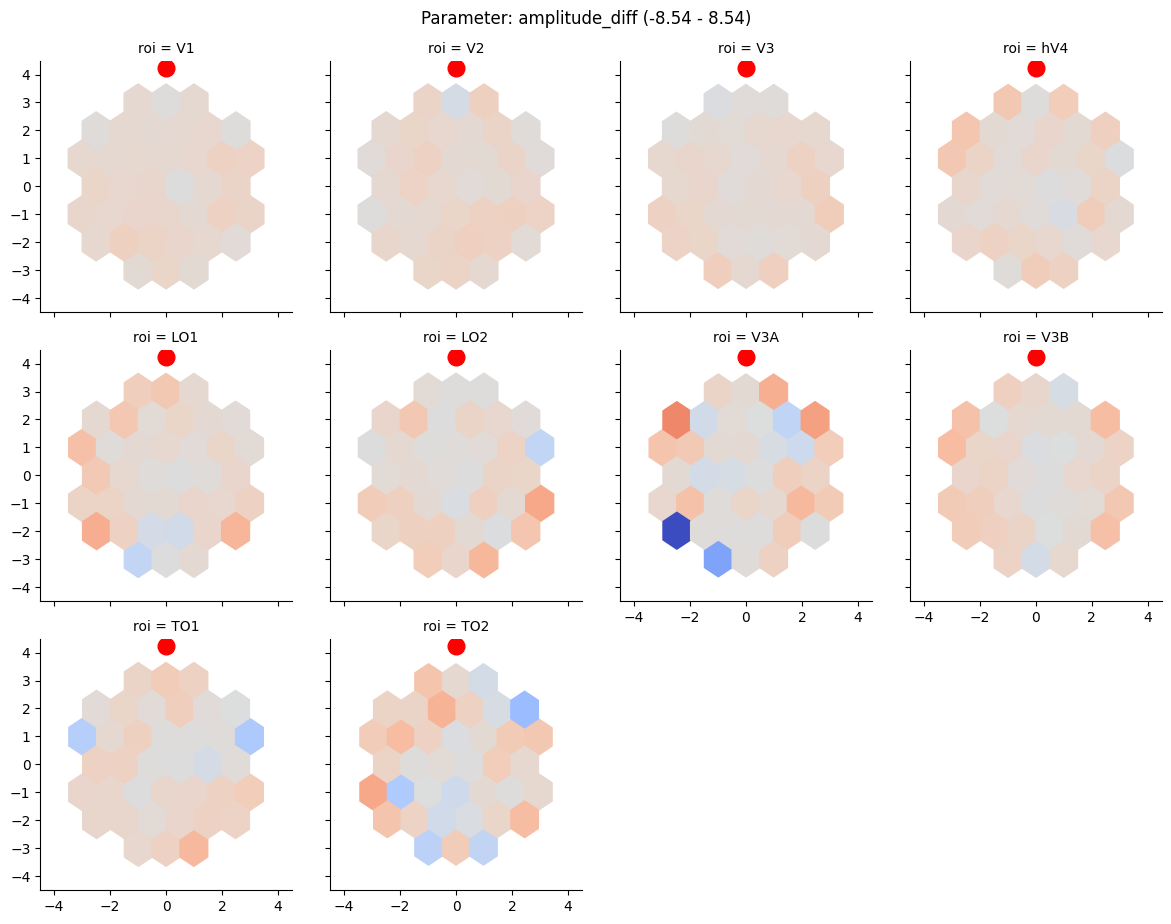

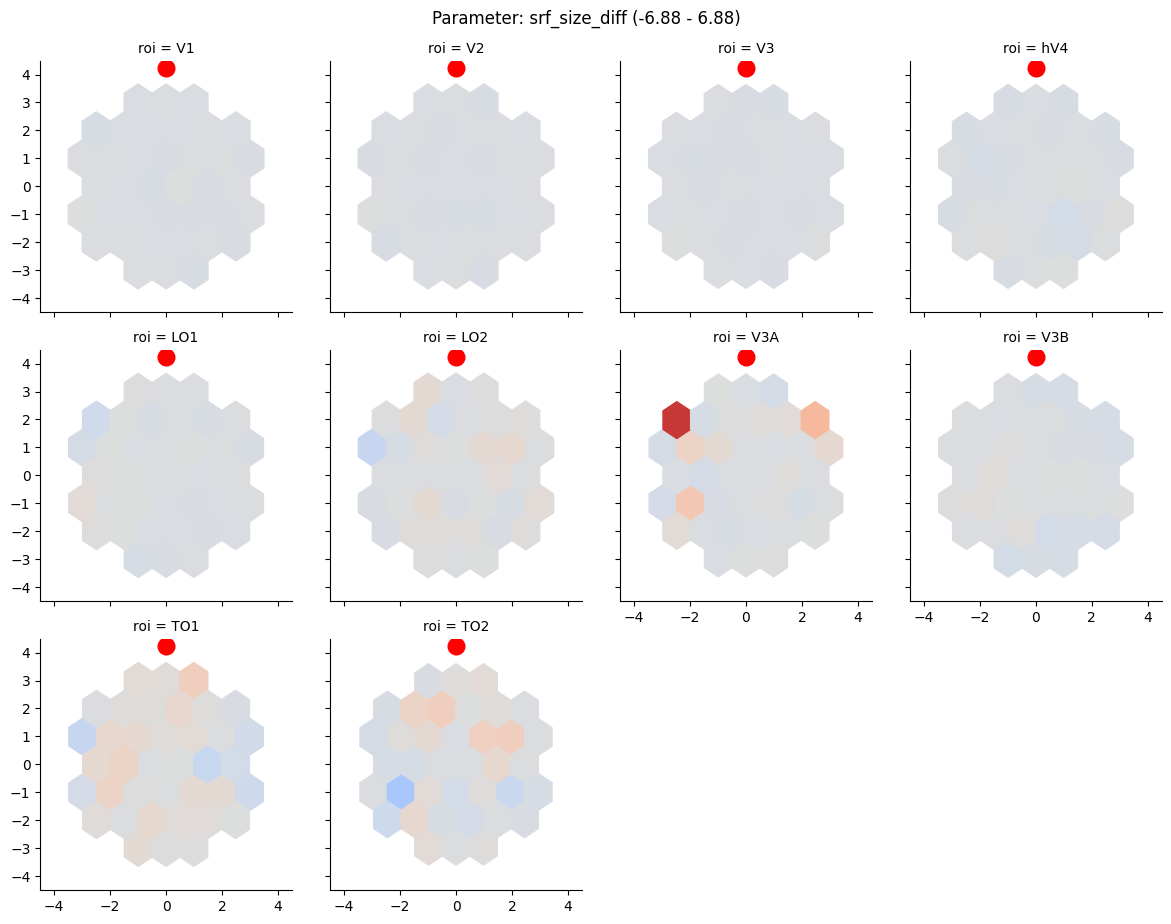

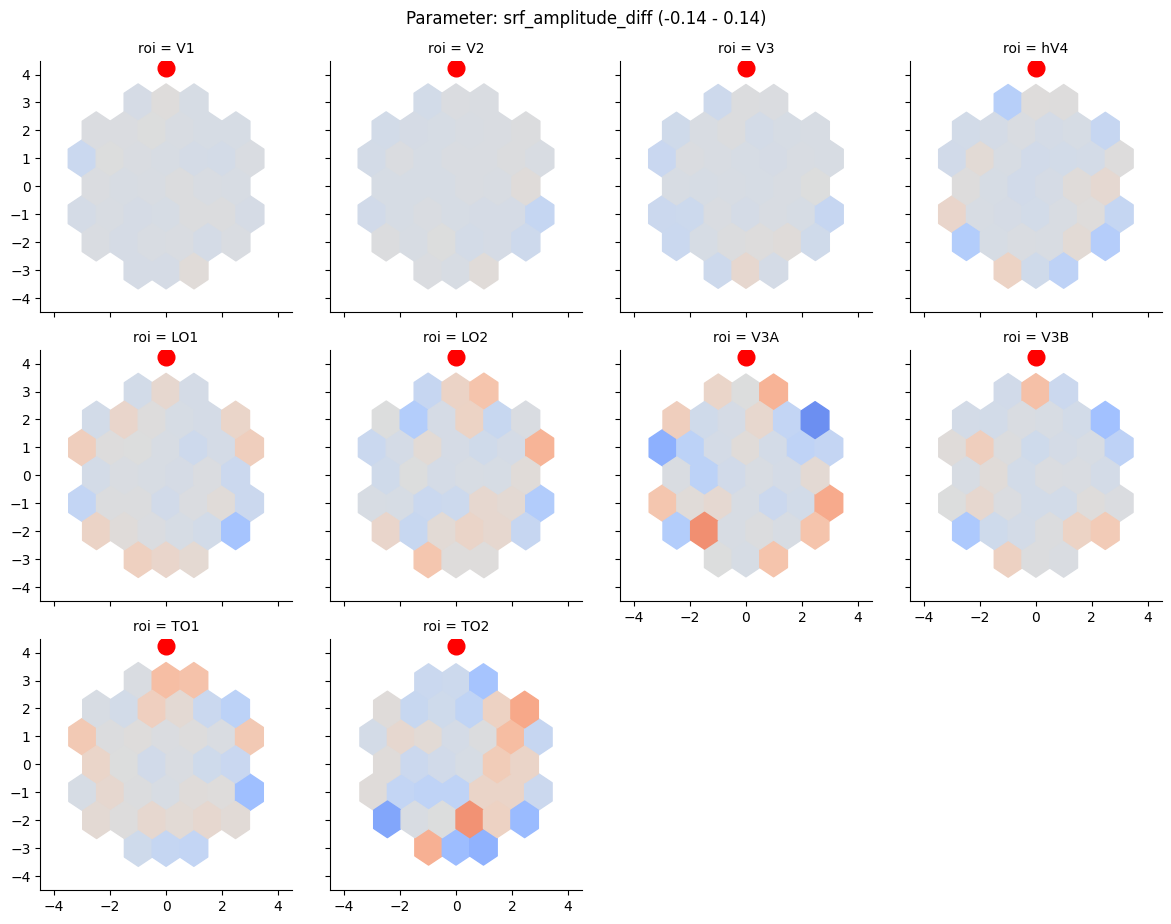

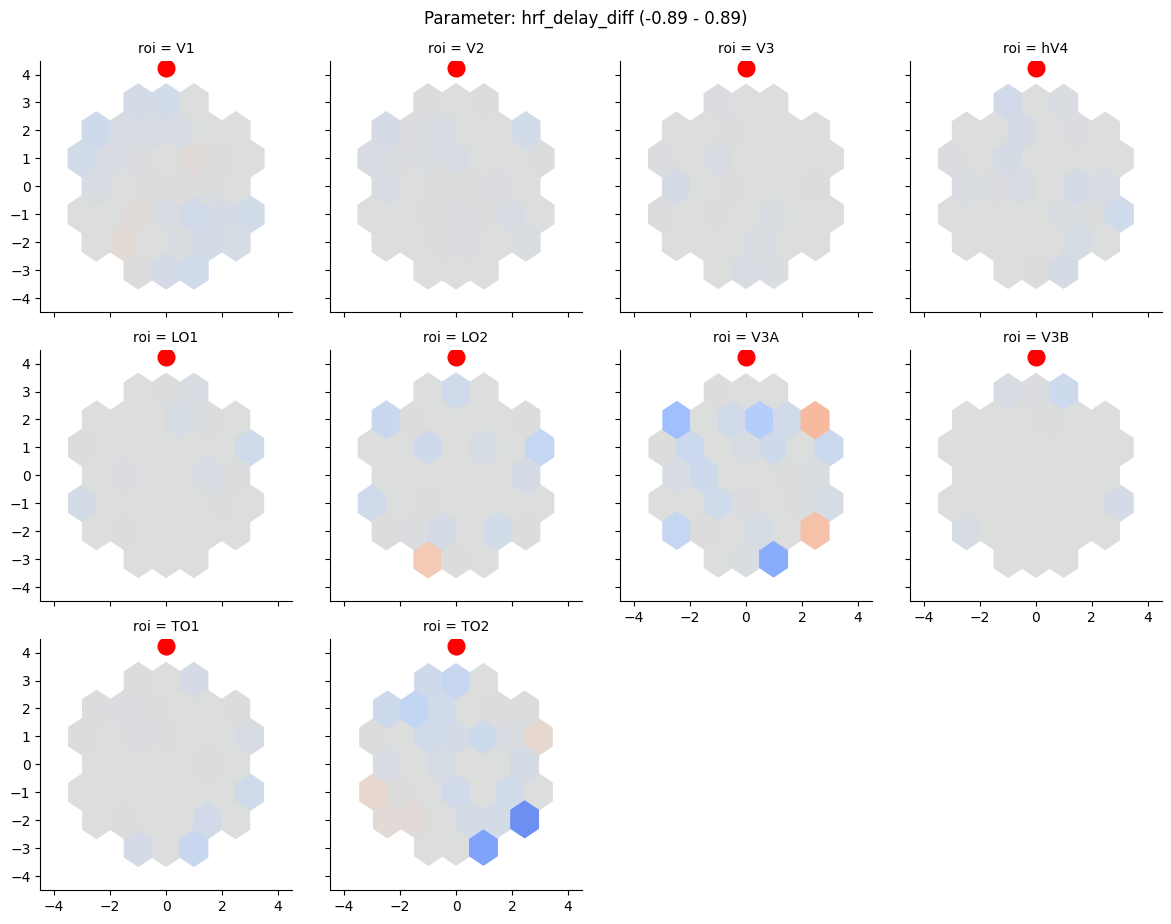

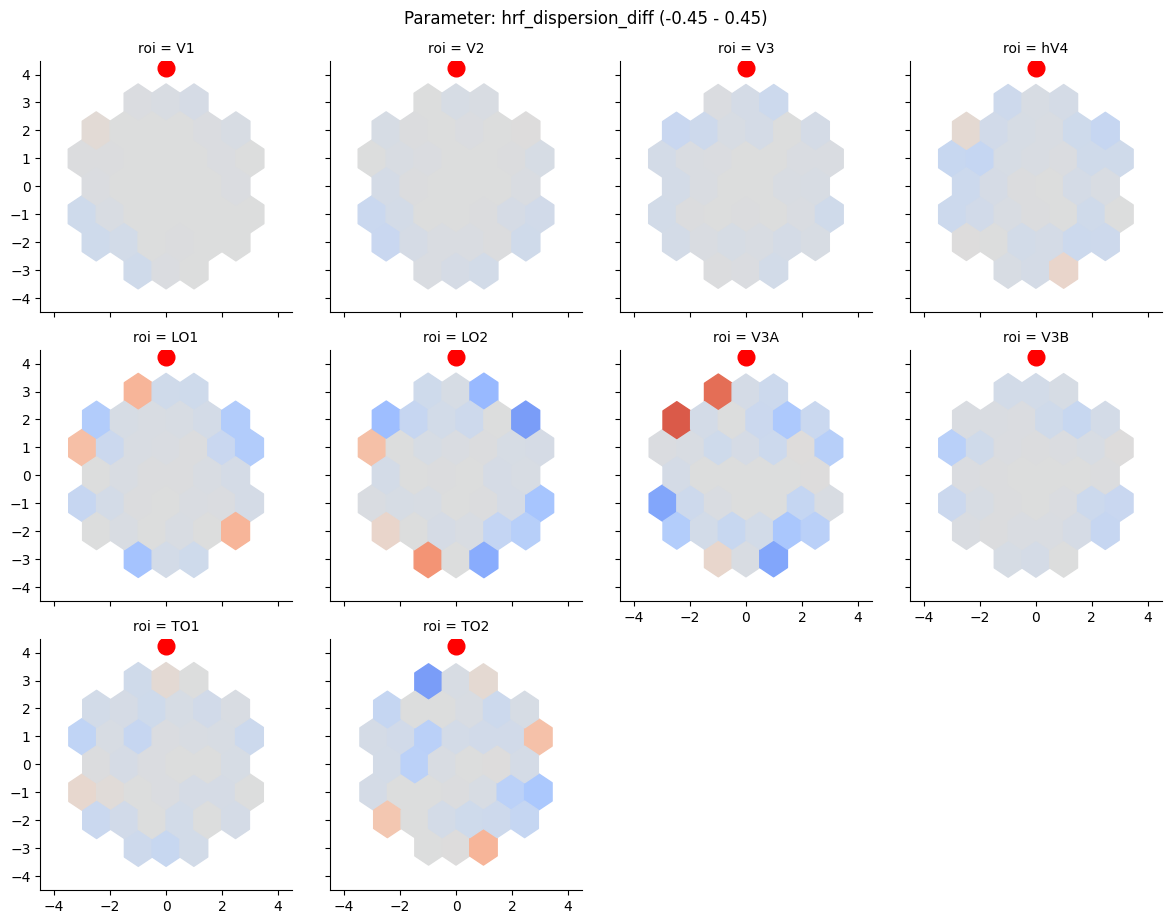

In [ ]:
data['distance_to_distractor_diff_norm'] = data['distance_to_distractor_diff'] / data['sd_mean']


import matplotlib.pyplot as plt

def plot_parameter_in_space(data, parameter='amplitude', vmin=0, vmax=3, **kwargs):
    distractor_label = data['distractor_location'].iloc[0] if 'distractor_location' in data else None
    x, y, C = data[['x_mean_rotated', 'y_mean_rotated', parameter]].values.T
    plt.hexbin(x, y, C=C, gridsize=6, cmap='coolwarm', reduce_C_function=np.median, vmin=vmin, vmax=vmax)
    plt.xlim(-4.5, 4.5)
    plt.ylim(-4.5, 4.5)
    plt.gca().set_aspect('equal', adjustable='box')
    sns.despine()

    plt.plot(0.0, 4.25, 'ro', markersize=12, label='Distractor')

def get_symmetric_quantile_range(series, q=0.2):
    # Get the absolute max of the lower and upper quantiles
    lower = series.quantile(q)
    upper = series.quantile(1 - q)
    bound = max(abs(lower), abs(upper))
    return -bound, bound

params = [
    'distance_to_distractor_mean',
    'distance_to_distractor_diff',
    'distance_to_distractor_diff_norm',
    'x_diff', 'y_diff', 'sd_diff', 'ecc_diff', 'amplitude_diff',
    'srf_size_diff', 'srf_amplitude_diff', 'hrf_delay_diff', 'hrf_dispersion_diff'
]

roi_order = ['V1', 'V2', 'V3', 'hV4', 'LO1', 'LO2', 'V3A', 'V3B', 'TO1','TO2']
filtered = data[data['r2_mean'] > 0.1].query('ecc_mean < 3.0').reset_index()


for param in params:
    vmin, vmax = get_symmetric_quantile_range(filtered[param], q=0.1)
    g = sns.FacetGrid(filtered, col='roi', col_order=roi_order, col_wrap=4)
    g.map_dataframe(plot_parameter_in_space, parameter=param, vmin=vmin, vmax=vmax)
    g.fig.suptitle(f'Parameter: {param} ({vmin:.2f} - {vmax:.2f})', y=1.02)
    plt.show()

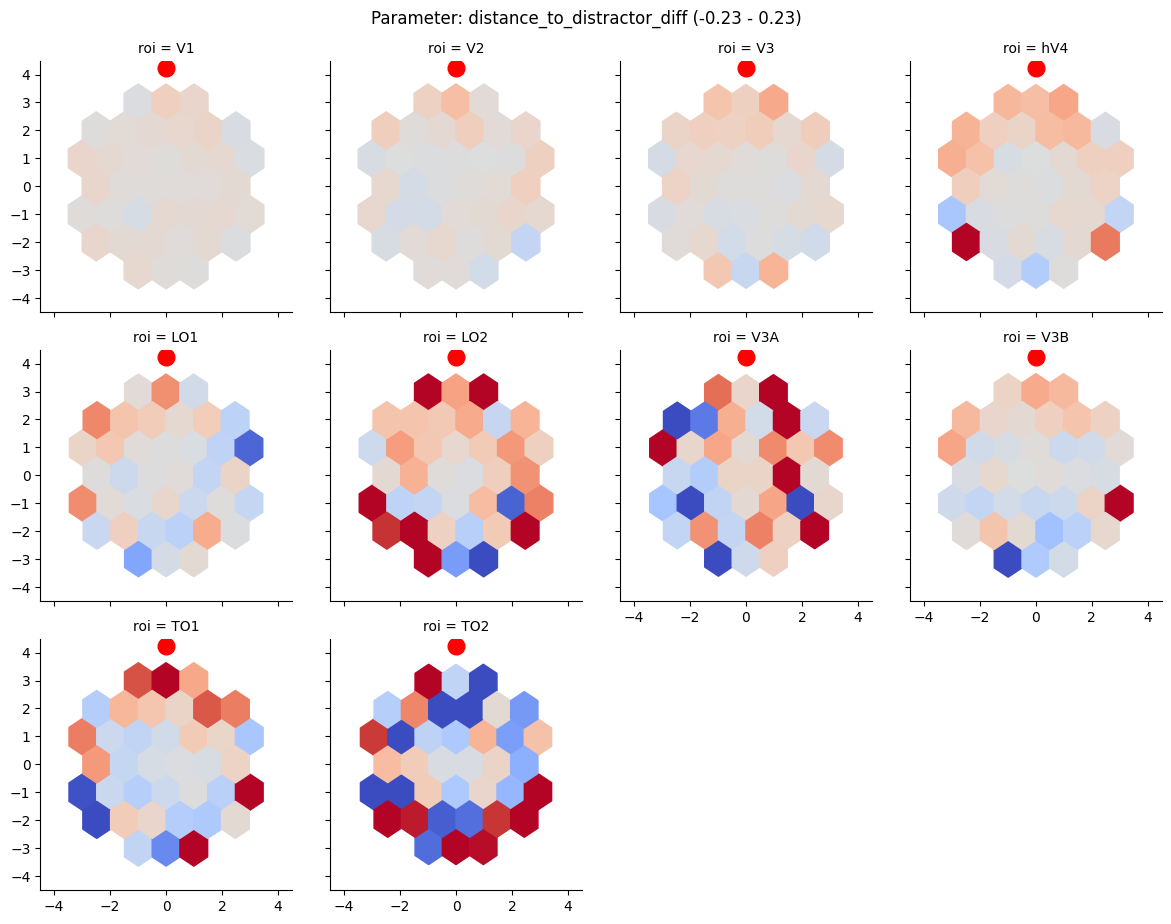

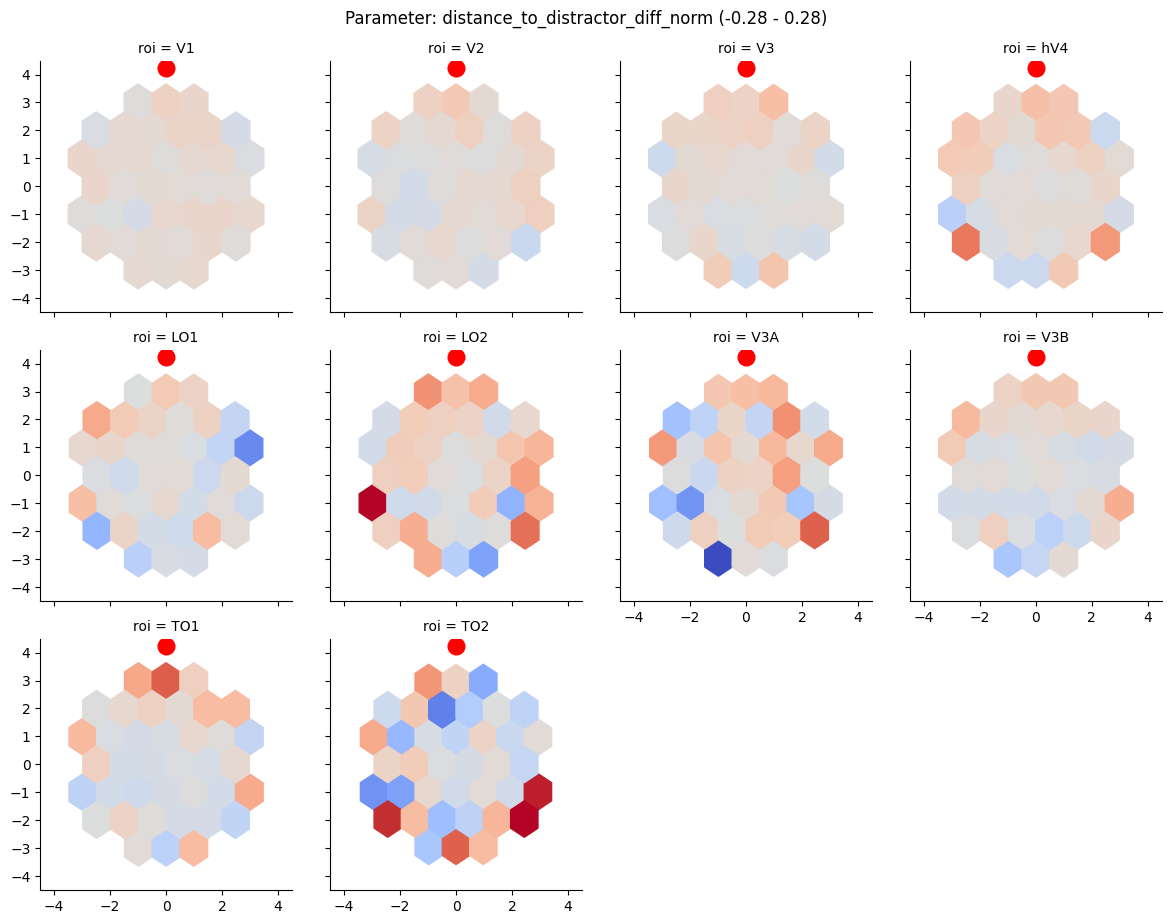

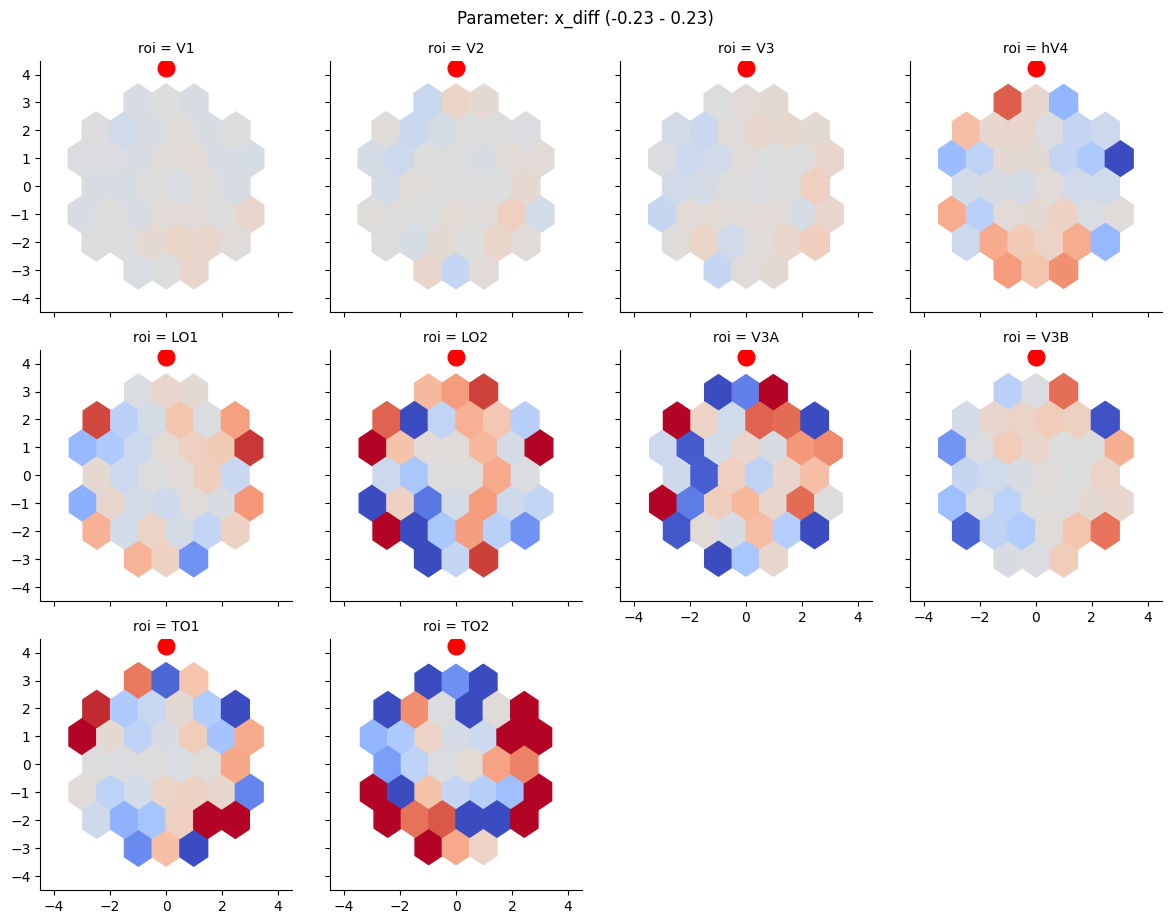

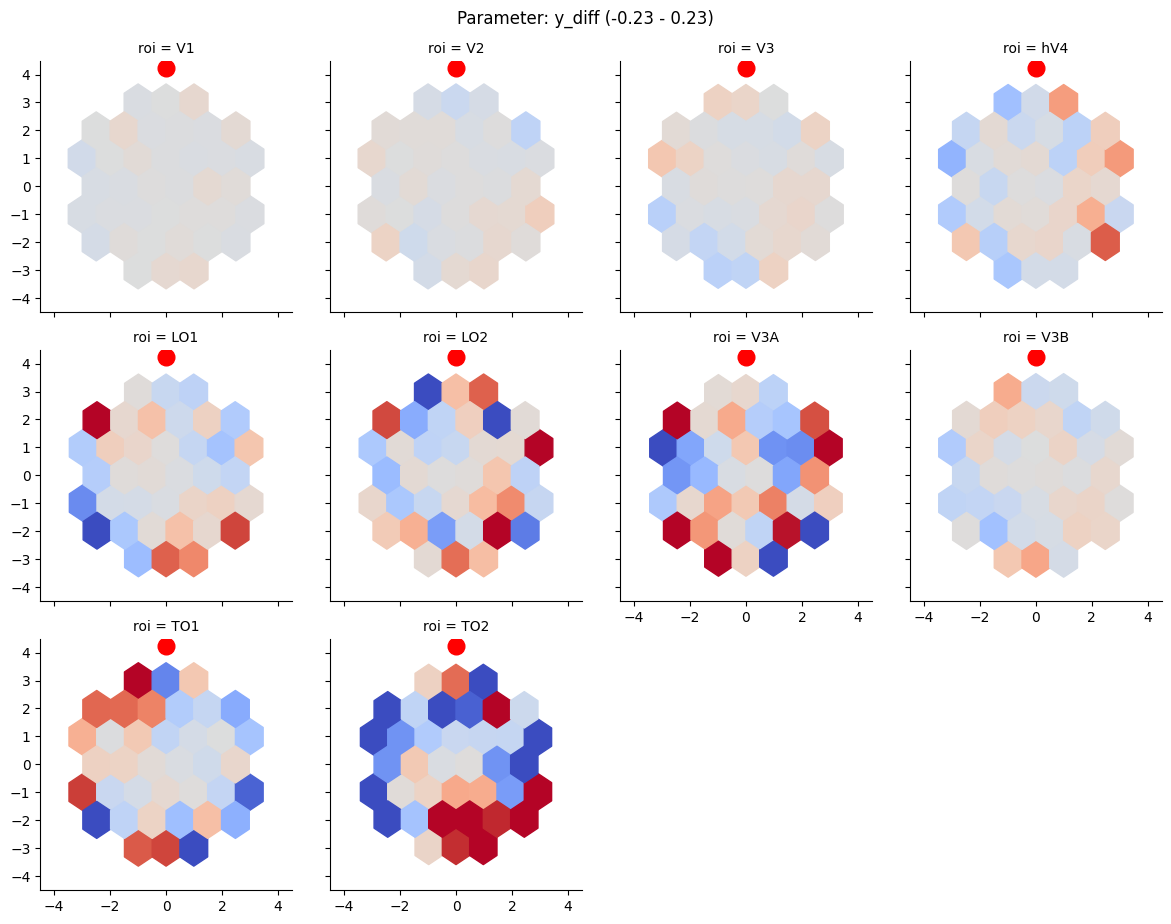

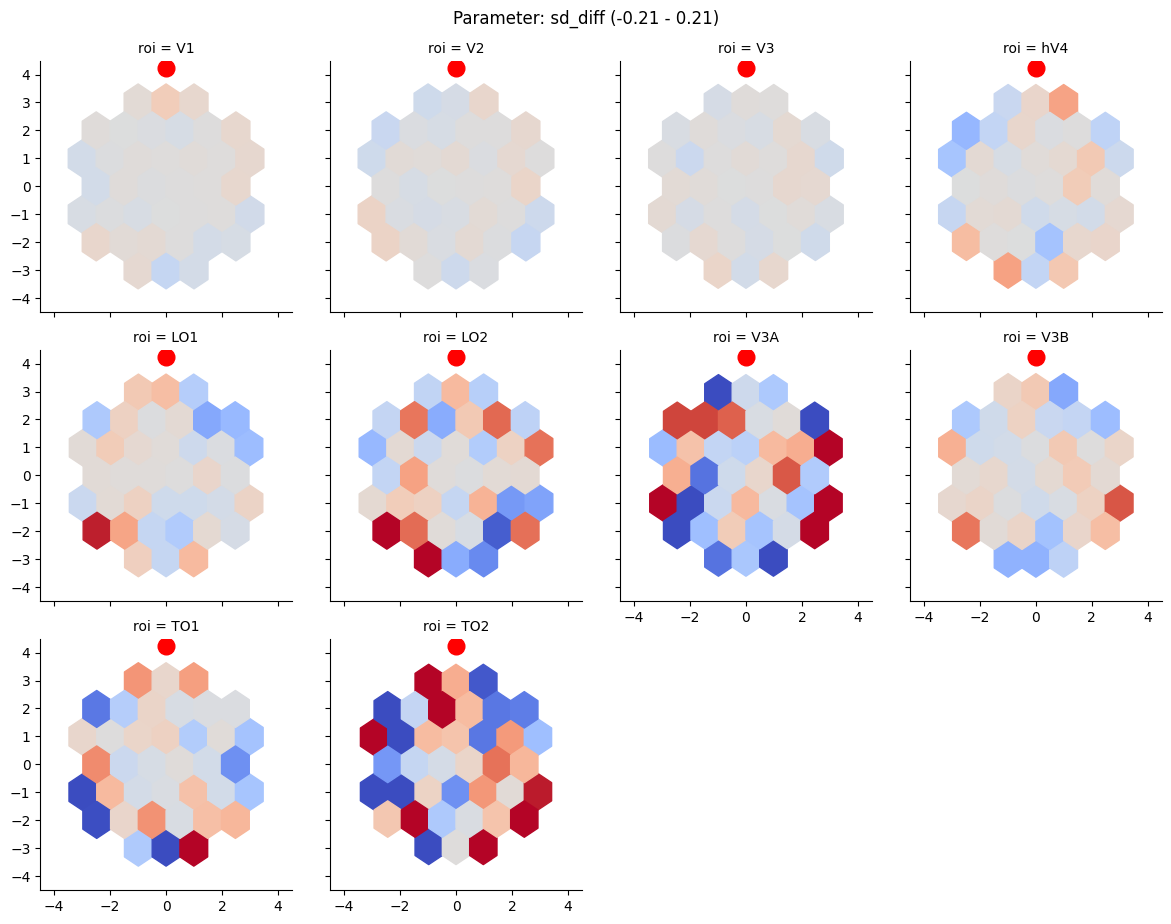

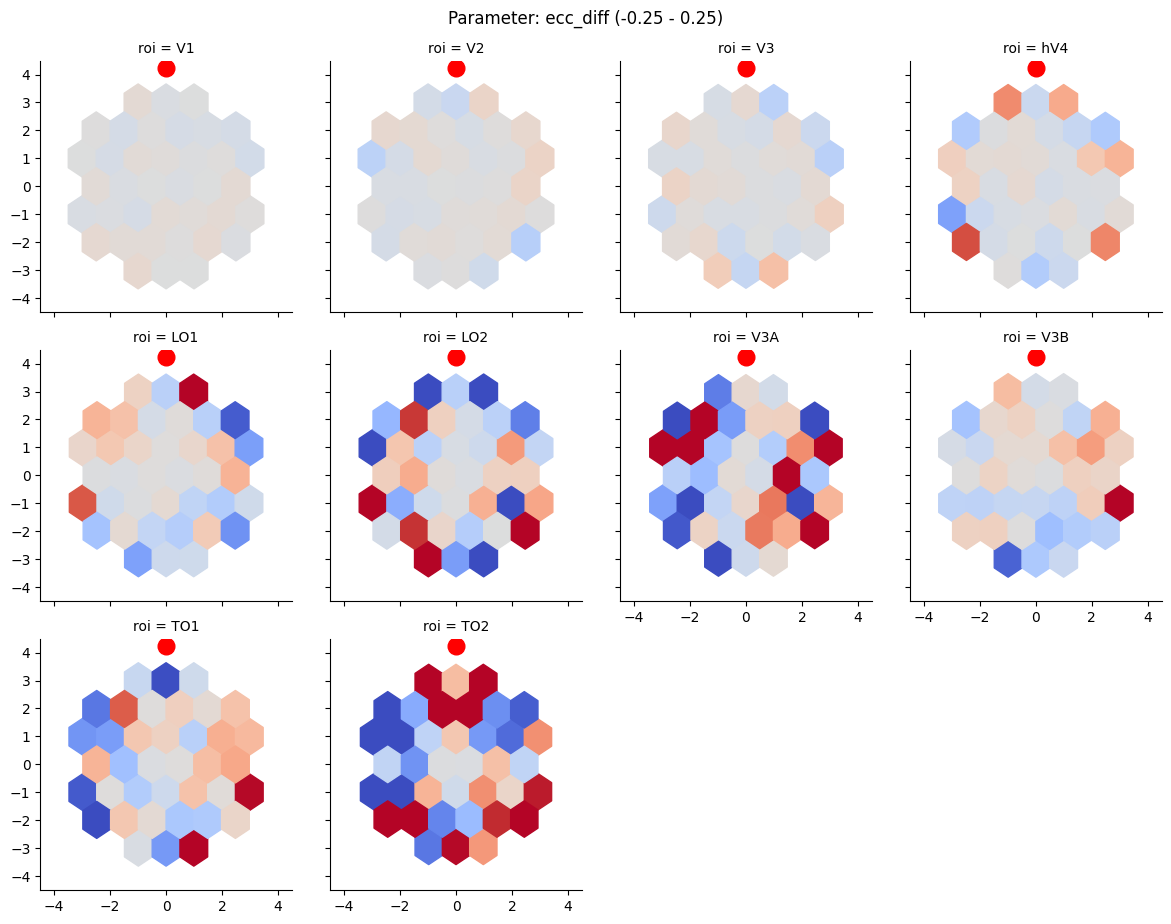

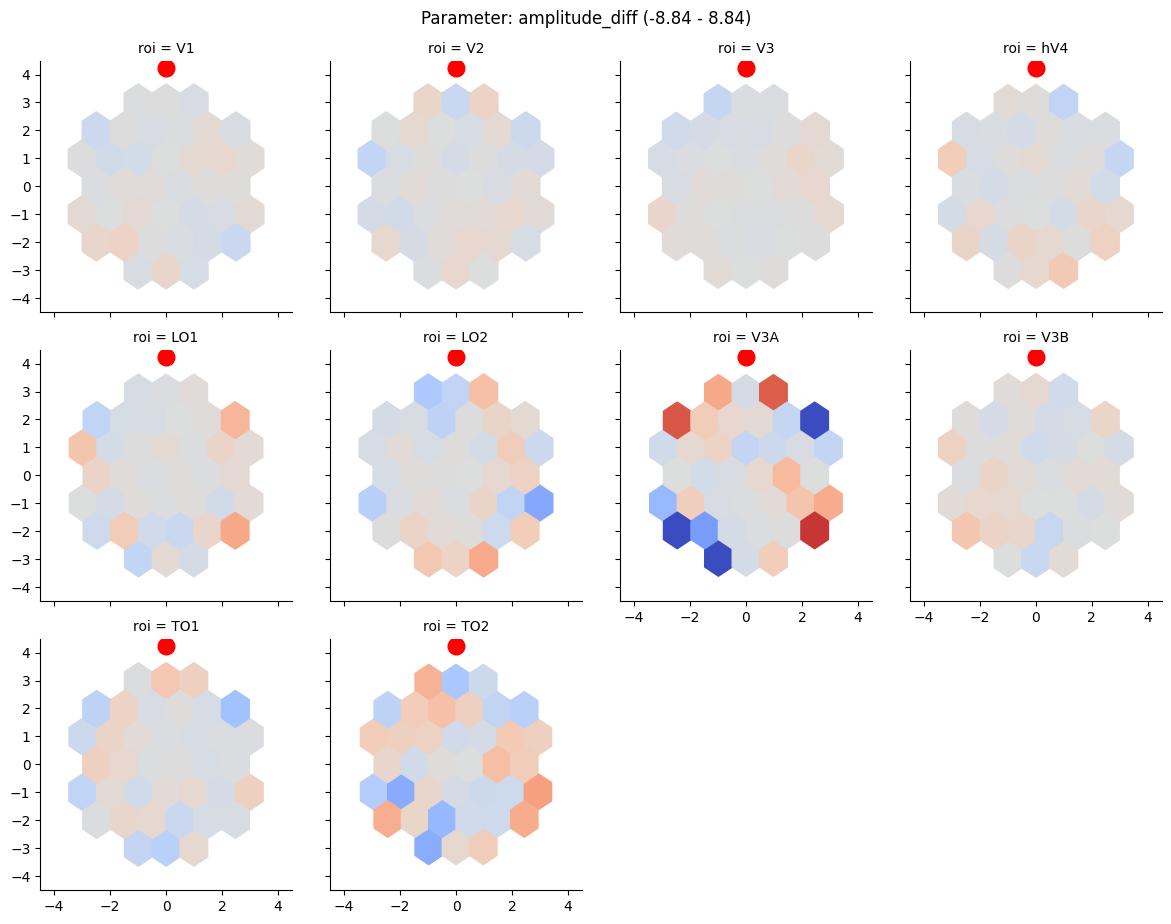

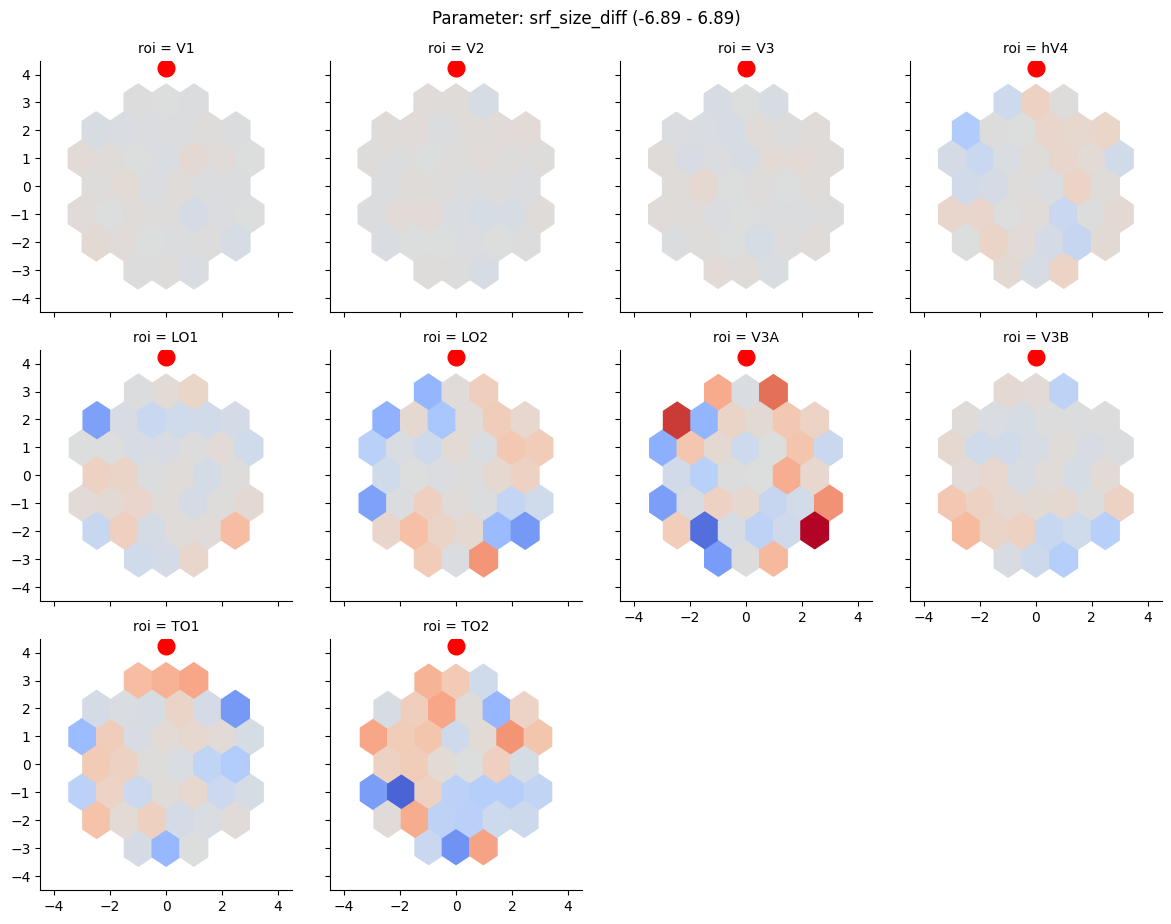

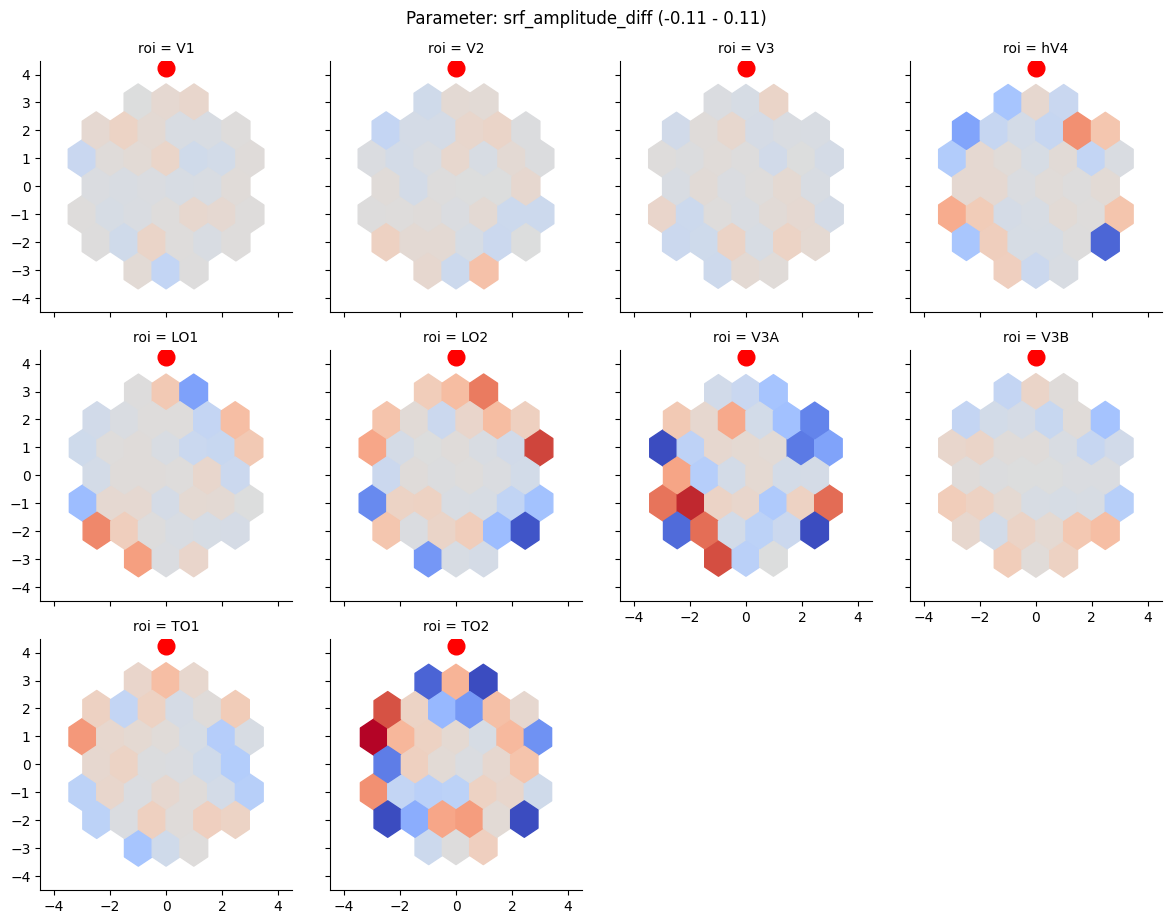

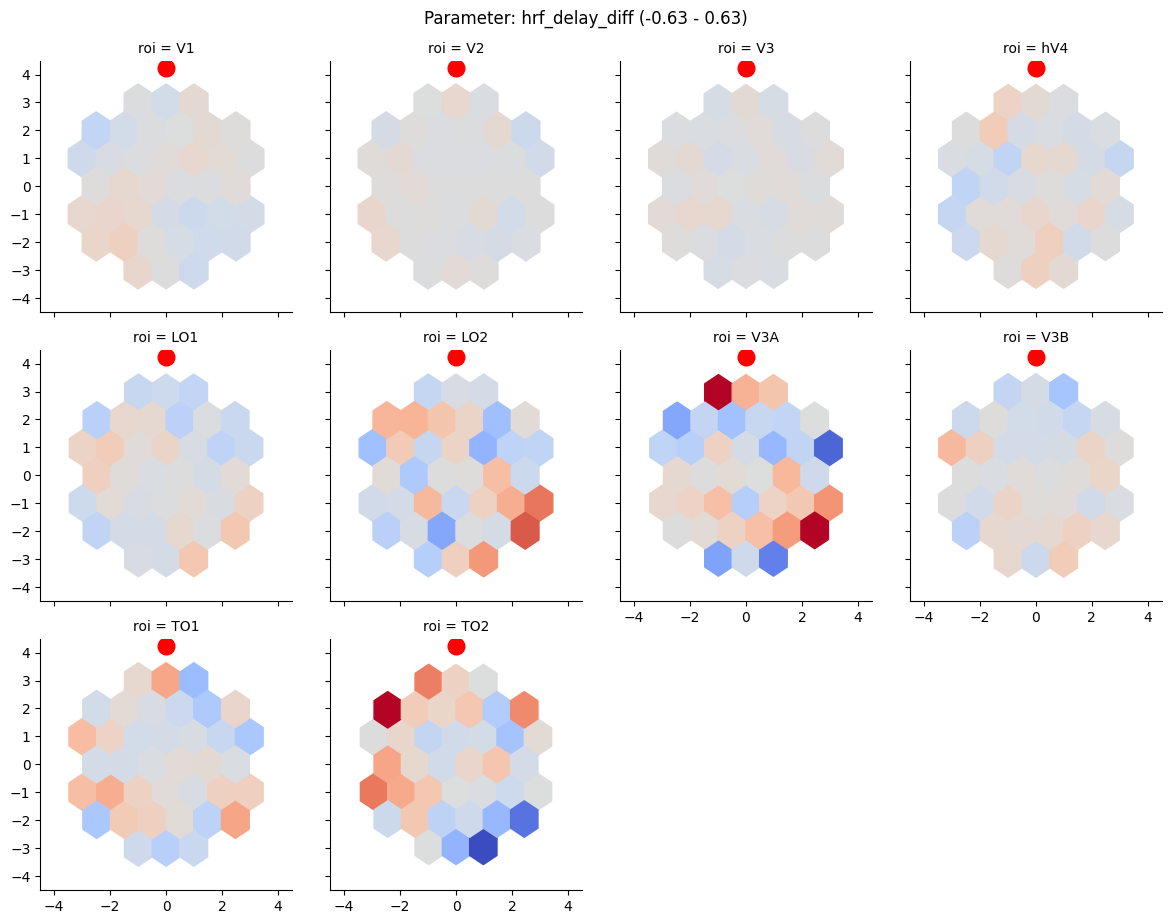

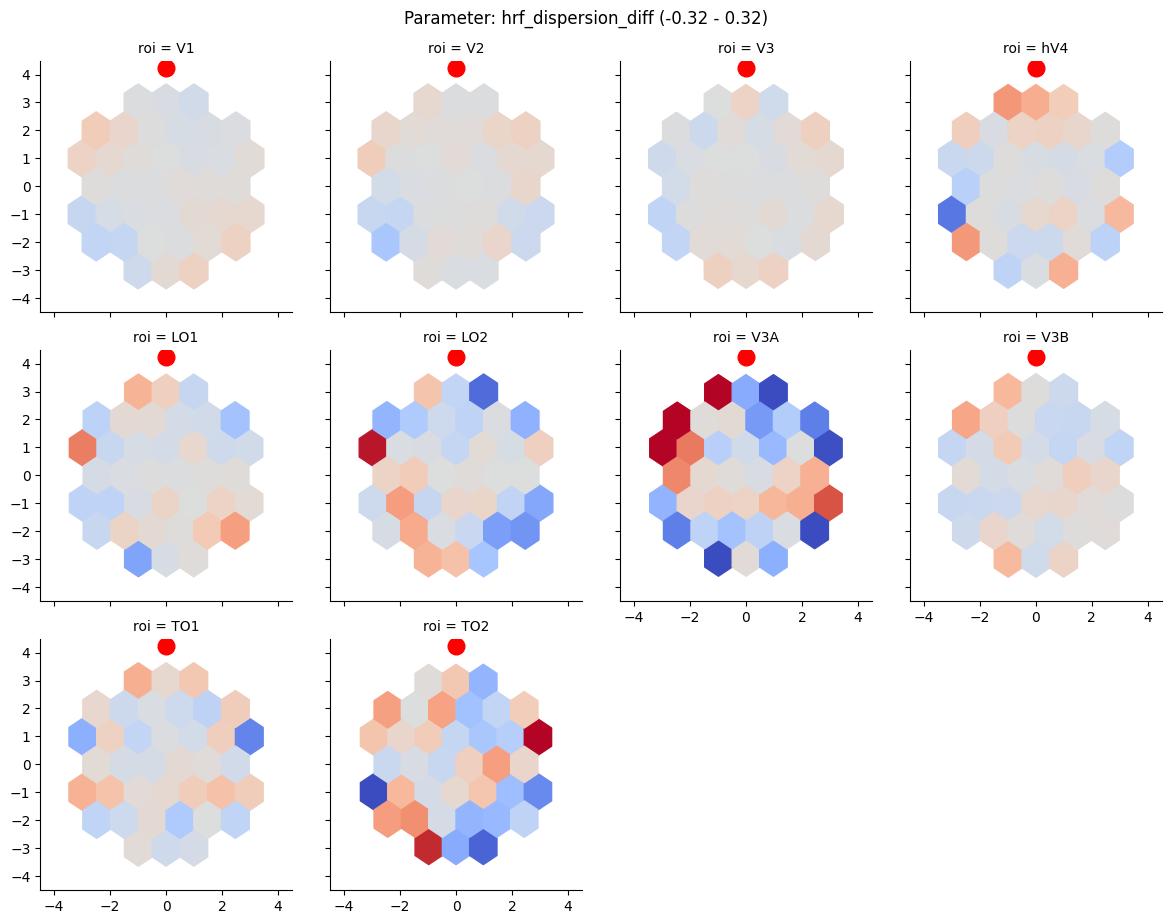

In [ ]:
data['distance_to_distractor_diff_norm'] = data['distance_to_distractor_diff'] / data['sd_mean']


import matplotlib.pyplot as plt

def plot_parameter_in_space(data, parameter='amplitude', vmin=0, vmax=3, **kwargs):
    distractor_label = data['distractor_location'].iloc[0] if 'distractor_location' in data else None
    x, y, C = data[['x_mean_rotated', 'y_mean_rotated', parameter]].values.T
    plt.hexbin(x, y, C=C, gridsize=6, cmap='coolwarm', reduce_C_function=np.mean, vmin=vmin, vmax=vmax)
    plt.xlim(-4.5, 4.5)
    plt.ylim(-4.5, 4.5)
    plt.gca().set_aspect('equal', adjustable='box')
    sns.despine()

    plt.plot(0.0, 4.25, 'ro', markersize=12, label='Distractor')

def get_symmetric_quantile_range(series, q=0.1):
    # Get the absolute max of the lower and upper quantiles
    lower = series.quantile(q)
    upper = series.quantile(1 - q)
    bound = max(abs(lower), abs(upper))
    return -bound, bound

params = [
    # 'distance_to_distractor_mean',
    'distance_to_distractor_diff',
    'distance_to_distractor_diff_norm',
    'x_diff', 'y_diff', 'sd_diff', 'ecc_diff', 'amplitude_diff',
    'srf_size_diff', 'srf_amplitude_diff', 'hrf_delay_diff', 'hrf_dispersion_diff'
]

roi_order = ['V1', 'V2', 'V3', 'hV4', 'LO1', 'LO2', 'V3A', 'V3B', 'TO1','TO2']
filtered = data[data['r2_mean'] > 0.2].query('ecc_mean < 3.0').reset_index()


for param in params:
    vmin, vmax = get_symmetric_quantile_range(filtered[param], q=0.1)
    g = sns.FacetGrid(filtered, col='roi', col_order=roi_order, col_wrap=4)
    g.map_dataframe(plot_parameter_in_space, parameter=param, vmin=vmin, vmax=vmax)
    g.fig.suptitle(f'Parameter: {param} ({vmin:.2f} - {vmax:.2f})', y=1.02)
    plt.show()

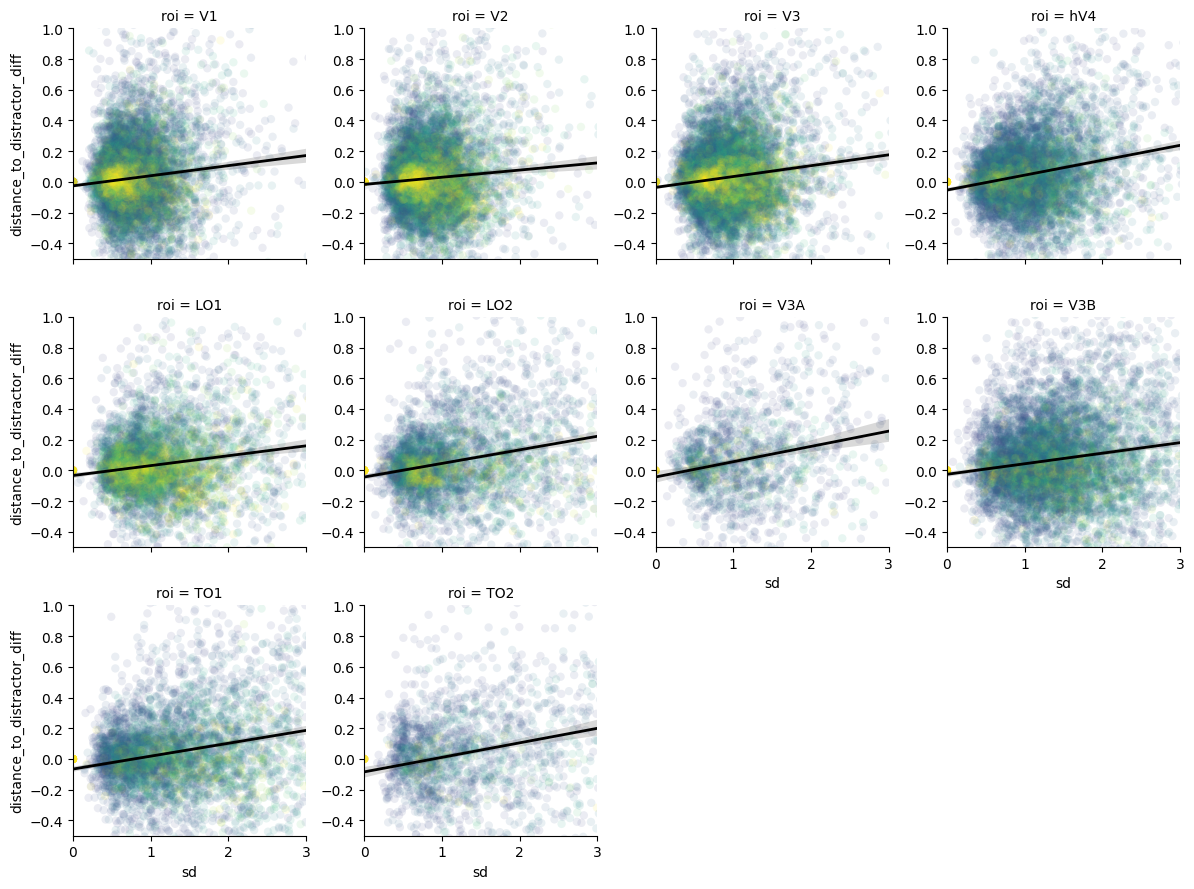

In [ ]:
# sns.regplot(x='sd', y='distance_to_distractor_diff', data=data.xs('V1', level='roi')) 


tmp = data.groupby(['subject', 'roi', 'voxel',])[['sd', 'distance_to_distractor_diff', 'r2']].mean()
g = sns.FacetGrid(tmp[tmp['r2'] > 0.1].reset_index(), col_wrap=4, sharey=False, col='roi', col_order=roi_order)

g.map_dataframe(sns.scatterplot, 'sd', 'distance_to_distractor_diff', alpha=0.1, hue='r2', hue_norm=(0.0, 0.5), palette='viridis',
                edgecolor='none')
# Regplot without scatter
g.map_dataframe(sns.regplot, 'sd', 'distance_to_distractor_diff', scatter=False, color='black', line_kws={'linewidth':2})
# g.map_dataframe(sns.scatterplot, 'sd', 'distance_to_distractor_diff', alpha=0.3, hue='r2')

g.set(xlim=(0, 3), ylim=(-.5, 1.))

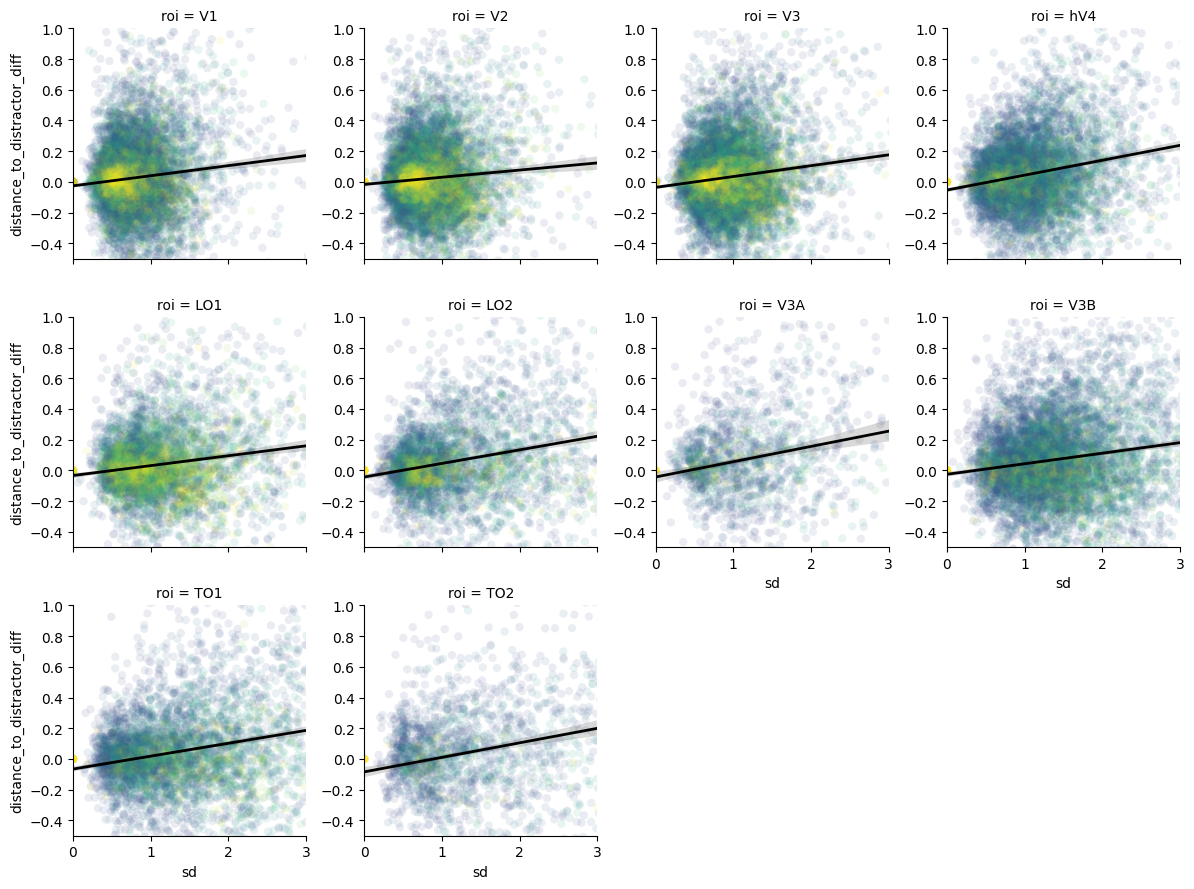

In [ ]:
# sns.regplot(x='sd', y='distance_to_distractor_diff', data=data.xs('V1', level='roi')) 


tmp = data.groupby(['subject', 'roi', 'voxel',])[['sd', 'distance_to_distractor_diff', 'r2']].mean()
g = sns.FacetGrid(tmp[tmp['r2'] > 0.1].reset_index(), col_wrap=4, sharey=False, col='roi', col_order=roi_order)

g.map_dataframe(sns.scatterplot, 'sd', 'distance_to_distractor_diff', alpha=0.1, hue='r2', hue_norm=(0.0, 0.5), palette='viridis',
                edgecolor='none')
# Regplot without scatter
g.map_dataframe(sns.regplot, 'sd', 'distance_to_distractor_diff', scatter=False, color='black', line_kws={'linewidth':2})
# g.map_dataframe(sns.scatterplot, 'sd', 'distance_to_distractor_diff', alpha=0.3, hue='r2')

g.set(xlim=(0, 3), ylim=(-.5, 1.))

/Users/gdehol/mambaforge/envs/retsupp/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 26.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/gdehol/mambaforge/envs/retsupp/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 30.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/gdehol/mambaforge/envs/retsupp/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 36.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/gdehol/mambaforge/envs/retsupp/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 16.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


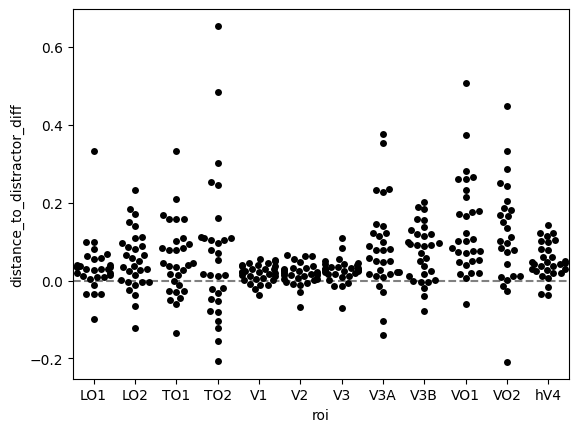

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Prepare data
tmp = data[data['r2_mean'] > 0.1].groupby(['roi', 'subject'])[['distance_to_distractor_diff']].mean().reset_index()


g = sns.swarmplot(x="roi", y="distance_to_distractor_diff", data=tmp, color="k")

plt.axhline(0, color='gray', linestyle='--')

In [24]:
tmp['subject'].unique()

array(['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11',
       '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22',
       '23', '24', '25', '26', '27', '28', '29', '30'], dtype=object)

In [25]:
data['distance_to_distractor_diff_norm'] = data['distance_to_distractor_diff'] / data['sd_mean']

<Axes: xlabel='None-roi', ylabel='None-roi'>

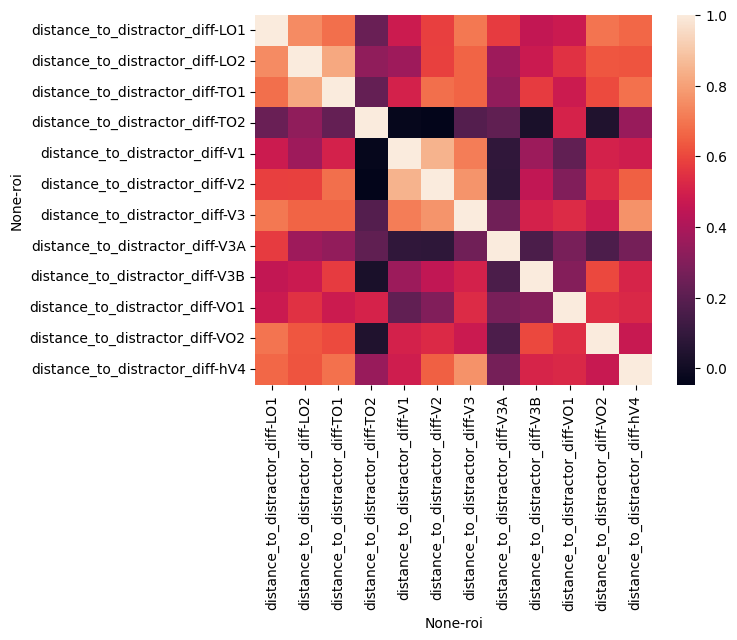

In [26]:
sns.heatmap(data[data.r2 > 0.2].groupby(['subject', 'roi'])[['distance_to_distractor_diff']].mean().unstack('roi').corr())

<Axes: xlabel='None-roi', ylabel='None-roi'>

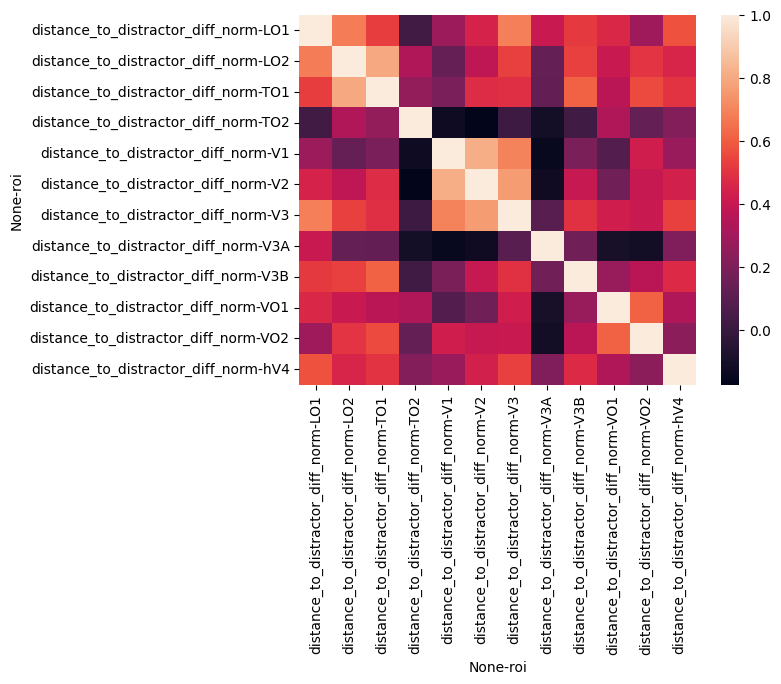

In [27]:
sns.heatmap(data[data.r2 > 0.2].groupby(['subject', 'roi'])[['distance_to_distractor_diff_norm']].mean().unstack('roi').corr())

/Users/gdehol/mambaforge/envs/retsupp/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 26.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/gdehol/mambaforge/envs/retsupp/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 30.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/gdehol/mambaforge/envs/retsupp/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 36.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/gdehol/mambaforge/envs/retsupp/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 16.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


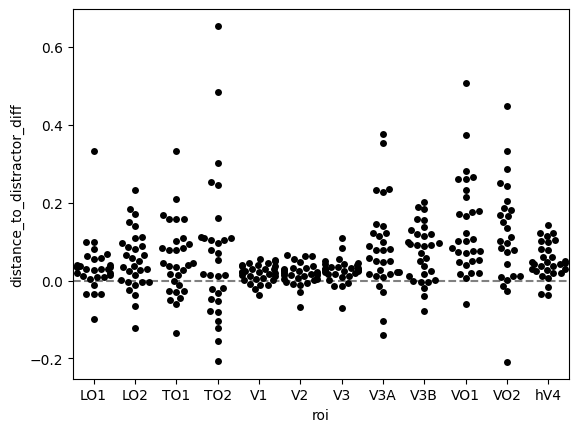

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Prepare data
tmp = data[data['r2_mean'] > 0.1].groupby(['roi', 'subject'])[['distance_to_distractor_diff']].mean().reset_index()


g = sns.swarmplot(x="roi", y="distance_to_distractor_diff", data=tmp, color="k")

plt.axhline(0, color='gray', linestyle='--')

In [33]:
tmp

roi subject  distance_to_distractor_diff
0    LO1      01                    -0.098571
1    LO1      02                     0.100259
2    LO1      03                     0.068778
3    LO1      04                     0.058532
4    LO1      05                     0.009139
..   ...     ...                          ...
351  hV4      26                     0.028898
352  hV4      27                     0.121146
353  hV4      28                     0.143495
354  hV4      29                     0.044722
355  hV4      30                     0.061034

[356 rows x 3 columns]

# Attention field

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Distractor coordinate mapping
def get_distractor_coords(label, radius=4.):
    mapping = {
        'upper_right': np.pi/4,
        'upper_left': 3*np.pi/4,
        'lower_left': 5*np.pi/4,
        'lower_right': 7*np.pi/4
    }
    angle = mapping.get(label, None)
    if angle is None:
        return None, None
    x = radius * np.cos(angle)
    y = radius * np.sin(angle)
    return x, y

# Define all distractor locations
distractor_names = ['upper_right', 'upper_left', 'lower_left', 'lower_right']
distractor_coords = {name: get_distractor_coords(name) for name in distractor_names}
distractor_x = np.array([coords[0] for coords in distractor_coords.values()])
distractor_y = np.array([coords[1] for coords in distractor_coords.values()])

def compute_net_shifts(prf_x, prf_y, prf_sd, current_condition, fixed_attention_sd, ratio):
    """Compute net shift from all 4 distractors with fixed main SD and ratio for others"""
    net_dx, net_dy = 0.0, 0.0

    for i, (dx, dy) in enumerate(zip(distractor_x, distractor_y)):
        # Current distractor gets fixed SD, others get fixed_SD/ratio
        if distractor_names[i] == current_condition:
            current_sd = fixed_attention_sd
        else:
            current_sd = fixed_attention_sd / ratio

        # Compute shift from this distractor
        dx_i = (dx - prf_x) * prf_sd**2 / (prf_sd**2 + current_sd**2)
        dy_i = (dy - prf_y) * prf_sd**2 / (prf_sd**2 + current_sd**2)

        # Add to net shift
        net_dx += dx_i
        net_dy += dy_i

    return net_dx, net_dy

def compute_error(df, fixed_attention_sd, ratio):
    """Calculate total error for given parameters"""
    total_error = 0

    for condition in distractor_names:
        if condition in df['condition'].unique():
            group = df[df['condition'] == condition]
            for _, row in group.iterrows():
                # Get predicted shifts
                dx, dy = compute_net_shifts(
                    row['x_mean'], row['y_mean'], row['sd_mean'],
                    condition, fixed_attention_sd, ratio
                )
                predicted_shift = np.sqrt(dx**2 + dy**2)

                # Empirical shift
                empirical_shift = np.sqrt(
                    (row['x'] - row['x_mean'])**2 + (row['y'] - row['y_mean'])**2
                )

                # Add to error
                total_error += (predicted_shift - empirical_shift)**2

                # Also consider relative shift error
                attention_x, attention_y = distractor_coords[condition]
                predicted_new_x = row['x_mean'] + dx
                predicted_new_y = row['y_mean'] + dy
                predicted_new_dist = np.sqrt(
                    (predicted_new_x - attention_x)**2 + (predicted_new_y - attention_y)**2
                )
                empirical_new_dist = np.sqrt(
                    (row['x'] - attention_x)**2 + (row['y'] - attention_y)**2
                )
                original_dist = np.sqrt(
                    (row['x_mean'] - attention_x)**2 + (row['y_mean'] - attention_y)**2
                )

                relative_error = (
                    (predicted_new_dist - original_dist) -
                    (empirical_new_dist - original_dist)
                )**2
                total_error += relative_error

    return total_error

def compute_condition_shifts(df, current_condition, fixed_attention_sd, ratio):
    """Compute all shifts for one condition with given parameters"""
    group = df[df['condition'] == current_condition].copy()
    attention_x, attention_y = distractor_coords[current_condition]

    # Empirical shifts
    group['empirical_dx'] = group['x'] - group['x_mean']
    group['empirical_dy'] = group['y'] - group['y_mean']
    group['empirical_shift'] = np.sqrt(group['empirical_dx']**2 + group['empirical_dy']**2)

    # Empirical shift relative to current distractor
    group['original_dist'] = np.sqrt((group['x_mean'] - attention_x)**2 + (group['y_mean'] - attention_y)**2)
    group['new_dist'] = np.sqrt((group['x'] - attention_x)**2 + (group['y'] - attention_y)**2)
    group['empirical_shift_relative'] = group['new_dist'] - group['original_dist']

    # Predicted shifts from all distractors
    group['predicted_dx'], group['predicted_dy'] = zip(*[
        compute_net_shifts(x, y, sd, current_condition, fixed_attention_sd, ratio)
        for x, y, sd in zip(group['x_mean'], group['y_mean'], group['sd_mean'])
    ])
    group['predicted_shift'] = np.sqrt(group['predicted_dx']**2 + group['predicted_dy']**2)

    # Predicted shift relative to current distractor
    group['predicted_new_x'] = group['x_mean'] + group['predicted_dx']
    group['predicted_new_y'] = group['y_mean'] + group['predicted_dy']
    group['predicted_new_dist'] = np.sqrt(
        (group['predicted_new_x'] - attention_x)**2 + (group['predicted_new_y'] - attention_y)**2
    )
    group['predicted_shift_relative'] = group['predicted_new_dist'] - group['original_dist']

    # Store parameters
    group['fixed_attention_sd'] = fixed_attention_sd
    group['ratio'] = ratio
    group['main_attention_x'] = attention_x
    group['main_attention_y'] = attention_y

    return group

# Prepare data
test_pars = data.xs(('LO1', 3), level=['roi', 'subject'])

# Handle index and find condition column
if isinstance(test_pars.index, pd.MultiIndex):
    test_pars = test_pars.reset_index()
    condition_col = None
    for col in test_pars.columns:
        if test_pars[col].dtype == 'object' and any(name in distractor_names for name in test_pars[col].unique()):
            condition_col = col
            break

    if condition_col:
        test_pars = test_pars.rename(columns={condition_col: 'condition'})
    else:
        raise ValueError("Could not find condition column. Please check your data.")
else:
    test_pars = test_pars.reset_index()
    if 'condition' not in test_pars.columns:
        raise ValueError("No condition column found. Please specify it.")

# Select required columns
required_cols = ['x', 'y', 'sd', 'x_mean', 'y_mean', 'sd_mean', 'condition']
test_pars = test_pars[required_cols]

# Filter to only include our conditions
test_pars = test_pars[test_pars['condition'].isin(distractor_names)]

# Fix attention_sd to 10 and fit only ratio
fixed_attention_sd = 10.0

def fit_ratio(df, fixed_sd):
    """Fit only the ratio parameter with fixed attention_sd"""
    def error_function(ratio):
        return compute_error(df, fixed_sd, ratio[0])

    initial_guess = [2.0]  # ratio=2.0
    bounds = [(1.01, 100.0)]  # ratio > 1 means main distractor is stronger

    result = minimize(error_function, initial_guess, bounds=bounds)
    return result.x[0]

# Fit the model
best_ratio = fit_ratio(test_pars, fixed_attention_sd)
print(f"Fixed attention_sd: {fixed_attention_sd:.3f}")
print(f"Fitted ratio: {best_ratio:.3f}")

# Calculate error with best parameters
final_error = compute_error(test_pars, fixed_attention_sd, best_ratio)
print(f"Final error: {final_error:.2f}")

# Compute results for all conditions with best parameters
results = []
for condition in distractor_names:
    if condition in test_pars['condition'].unique():
        condition_results = compute_condition_shifts(
            test_pars, condition, fixed_attention_sd, best_ratio
        )
        results.append(condition_results)

# Combine results
final_df = pd.concat(results)

# Select and reorder columns
final_df = final_df[[
    # Original PRF parameters
    'condition', 'x_mean', 'y_mean', 'sd_mean',

    # Model parameters
    'fixed_attention_sd', 'ratio', 'main_attention_x', 'main_attention_y',

    # Empirical shifts
    'empirical_dx', 'empirical_dy', 'empirical_shift',
    'original_dist', 'new_dist', 'empirical_shift_relative',

    # Predicted shifts
    'predicted_dx', 'predicted_dy', 'predicted_shift',
    'predicted_new_dist', 'predicted_shift_relative'
]]

# Create visualizations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Total shift magnitudes
for condition in distractor_names:
    if condition in final_df['condition'].unique():
        condition_data = final_df[final_df['condition'] == condition]
        ax1.scatter(condition_data['empirical_shift'], condition_data['predicted_shift'],
                   alpha=0.5, label=condition)
ax1.plot([0, 3], [0, 3], 'r--')
ax1.set_xlabel('Empirical Total Shift')
ax1.set_ylabel('Predicted Total Shift')
ax1.set_title(f'Total Shifts (fixed_sd={fixed_attention_sd:.1f}, ratio={best_ratio:.2f})')
ax1.legend()
ax1.grid(True)

# Plot 2: Relative shifts
for condition in distractor_names:
    if condition in final_df['condition'].unique():
        condition_data = final_df[final_df['condition'] == condition]
        ax2.scatter(condition_data['empirical_shift_relative'], condition_data['predicted_shift_relative'],
                   alpha=0.1, label=condition)
ax2.plot([-2, 2], [-2, 2], 'r--')
ax2.set_xlabel('Empirical Relative Shift (positive = away)')
ax2.set_ylabel('Predicted Relative Shift (positive = away)')
ax2.set_title('Shifts Relative to Main Distractor')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# Return the complete dataframe
final_df


KeyError: 3

In [30]:
pars.index.unique(level='subject')

Index(['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24',
       '25', '26', '27', '28', '29', '30'],
      dtype='object', name='subject')

In [31]:
test_pars = pars[pars.ecc_mean < 3.0].xs(('V1', 28), level=['roi', 'subject']).reset_index()

KeyError: 28

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from matplotlib.colors import TwoSlopeNorm

# Distractor coordinate mapping
def get_distractor_coords(label, radius=4.):
    mapping = {
        'upper_right': np.pi/4,
        'upper_left': 3*np.pi/4,
        'lower_left': 5*np.pi/4,
        'lower_right': 7*np.pi/4
    }
    angle = mapping.get(label, None)
    if angle is None:
        return None, None
    x = radius * np.cos(angle)
    y = radius * np.sin(angle)
    return x, y

# Define all distractor locations
distractor_names = ['upper_right', 'upper_left', 'lower_left', 'lower_right']
distractor_coords = {name: get_distractor_coords(name) for name in distractor_names}
distractor_x = np.array([coords[0] for coords in distractor_coords.values()])
distractor_y = np.array([coords[1] for coords in distractor_coords.values()])

def compute_net_shifts(prf_x, prf_y, prf_sd, current_condition, fixed_attention_sd, log_ratio):
    """Compute net shift from all 4 distractors using log_ratio"""
    ratio = np.exp(log_ratio)  # Convert from log space to linear space
    net_dx, net_dy = 0.0, 0.0

    for i, (dx, dy) in enumerate(zip(distractor_x, distractor_y)):
        # Current distractor gets fixed SD
        # Other distractors get fixed_SD/ratio
        if distractor_names[i] == current_condition:
            current_sd = fixed_attention_sd
        else:
            current_sd = fixed_attention_sd / ratio

        # Compute shift from this distractor
        dx_i = (dx - prf_x) * prf_sd**2 / (prf_sd**2 + current_sd**2)
        dy_i = (dy - prf_y) * prf_sd**2 / (prf_sd**2 + current_sd**2)

        # Add to net shift
        net_dx += dx_i
        net_dy += dy_i

    return net_dx, net_dy

def compute_error(df, fixed_attention_sd, log_ratio):
    """Calculate total error for given parameters using log_ratio"""
    ratio = np.exp(log_ratio)
    total_error = 0

    for condition in distractor_names:
        if condition in df['condition'].unique():
            group = df[df['condition'] == condition]
            for _, row in group.iterrows():
                # Get predicted shifts
                dx, dy = compute_net_shifts(
                    row['x_mean'], row['y_mean'], row['sd_mean'],
                    condition, fixed_attention_sd, log_ratio
                )
                predicted_shift = np.sqrt(dx**2 + dy**2)

                # Empirical shift
                empirical_shift = np.sqrt(
                    (row['x'] - row['x_mean'])**2 + (row['y'] - row['y_mean'])**2
                )

                # Add to error
                total_error += (predicted_shift - empirical_shift)**2

                # Also consider relative shift error
                attention_x, attention_y = distractor_coords[condition]
                predicted_new_x = row['x_mean'] + dx
                predicted_new_y = row['y_mean'] + dy
                predicted_new_dist = np.sqrt(
                    (predicted_new_x - attention_x)**2 + (predicted_new_y - attention_y)**2
                )
                empirical_new_dist = np.sqrt(
                    (row['x'] - attention_x)**2 + (row['y'] - attention_y)**2
                )
                original_dist = np.sqrt(
                    (row['x_mean'] - attention_x)**2 + (row['y_mean'] - attention_y)**2
                )

                relative_error = (
                    (predicted_new_dist - original_dist) -
                    (empirical_new_dist - original_dist)
                )**2
                total_error += relative_error

    return total_error

def compute_condition_shifts(df, current_condition, fixed_attention_sd, log_ratio):
    """Compute all shifts for one condition using log_ratio"""
    ratio = np.exp(log_ratio)
    group = df[df['condition'] == current_condition].copy()
    attention_x, attention_y = distractor_coords[current_condition]

    # Empirical shifts
    group['empirical_dx'] = group['x'] - group['x_mean']
    group['empirical_dy'] = group['y'] - group['y_mean']
    group['empirical_shift'] = np.sqrt(group['empirical_dx']**2 + group['empirical_dy']**2)

    # Empirical shift relative to current distractor
    group['original_dist'] = np.sqrt((group['x_mean'] - attention_x)**2 + (group['y_mean'] - attention_y)**2)
    group['new_dist'] = np.sqrt((group['x'] - attention_x)**2 + (group['y'] - attention_y)**2)
    group['empirical_shift_relative'] = group['new_dist'] - group['original_dist']

    # Predicted shifts from all distractors
    group['predicted_dx'], group['predicted_dy'] = zip(*[
        compute_net_shifts(x, y, sd, current_condition, fixed_attention_sd, log_ratio)
        for x, y, sd in zip(group['x_mean'], group['y_mean'], group['sd_mean'])
    ])
    group['predicted_shift'] = np.sqrt(group['predicted_dx']**2 + group['predicted_dy']**2)

    # Predicted shift relative to current distractor
    group['predicted_new_x'] = group['x_mean'] + group['predicted_dx']
    group['predicted_new_y'] = group['y_mean'] + group['predicted_dy']
    group['predicted_new_dist'] = np.sqrt(
        (group['predicted_new_x'] - attention_x)**2 + (group['predicted_new_y'] - attention_y)**2
    )
    group['predicted_shift_relative'] = group['predicted_new_dist'] - group['original_dist']

    # Store parameters
    group['fixed_attention_sd'] = fixed_attention_sd
    group['log_ratio'] = log_ratio
    group['ratio'] = ratio  # Store both log and linear ratio
    group['main_attention_x'] = attention_x
    group['main_attention_y'] = attention_y

    return group

def fit_log_ratio(df, fixed_attention_sd):
    """Fit log_ratio parameter with fixed attention_sd"""
    def error_function(params):
        return compute_error(df, fixed_attention_sd, params[0])

    initial_guess = [0.0]  # log_ratio=0.0 corresponds to ratio=1.0
    bounds = [(-3, 3)]  # Allows ratio from exp(-3)≈0.05 to exp(3)≈20.08

    result = minimize(error_function, initial_guess, bounds=bounds)
    return result.x[0]

# Prepare data (assuming test_pars is already defined as in previous code)
fixed_attention_sd = 10.0

# Fit the model using log_ratio
best_log_ratio = fit_log_ratio(test_pars, fixed_attention_sd)
best_ratio = np.exp(best_log_ratio)

print(f"Fixed attention_sd: {fixed_attention_sd:.1f}")
print(f"Fitted log_ratio: {best_log_ratio:.3f}")
print(f"Fitted ratio (linear): {best_ratio:.3f}")

# Interpretation
if best_ratio > 1:
    print("(PRFs repelled from main distractor)")
elif best_ratio < 1:
    print("(PRFs may be attracted to main distractor)")
else:
    print("All distractors have equal strength")

# Calculate error with best parameters
final_error = compute_error(test_pars, fixed_attention_sd, best_log_ratio)
print(f"Final error: {final_error:.2f}")

# Compute results for all conditions with best parameters
results = []
for condition in distractor_names:
    if condition in test_pars['condition'].unique():
        condition_results = compute_condition_shifts(
            test_pars, condition, fixed_attention_sd, best_log_ratio
        )
        results.append(condition_results)

# Combine results
final_df = pd.concat(results)

# Create visualizations (same as before)
fig, axes = plt.subplots(2, 4, figsize=(24, 12))
fig.suptitle(f'Shifts Relative to Main Distractor (fixed_sd={fixed_attention_sd:.1f}, ratio={best_ratio:.2f})', y=1.01)

# Find global min/max for consistent color scaling across all plots
all_shifts = np.concatenate([
    final_df['empirical_shift_relative'].values,
    final_df['predicted_shift_relative'].values
])
global_vmax = max(abs(all_shifts.min()), abs(all_shifts.max()))
norm = TwoSlopeNorm(vmin=-global_vmax, vcenter=0, vmax=global_vmax)

# Create plots for each condition
for i, condition in enumerate(distractor_names):
    condition_data = final_df[final_df['condition'] == condition]
    attention_x, attention_y = distractor_coords[condition]

    # Empirical shifts plot (left column)
    ax = axes[0, i]
    hb = ax.hexbin(condition_data['x_mean'], condition_data['y_mean'],
                  C=condition_data['empirical_shift_relative'],
                  gridsize=7,
                  cmap='coolwarm', norm=norm, mincnt=1)
    ax.scatter(attention_x, attention_y, color='black', s=200, marker='*')
    ax.set_xlabel('X Position')
    ax.set_ylabel('Y Position')
    ax.set_title(f'{condition} - Empirical Shifts')
    fig.colorbar(hb, ax=ax, label='Relative Shift (red=away, blue=toward)')

    ax.set_xlim(-4., 4.)
    ax.set_ylim(-4., 4.)
    ax.set_aspect('equal')

    # Predicted shifts plot (right column)
    ax = axes[1, i]
    hb = ax.hexbin(condition_data['x_mean'], condition_data['y_mean'],
                  C=condition_data['predicted_shift_relative'],
                  gridsize=7,
                  cmap='coolwarm', norm=norm, mincnt=1)
    ax.scatter(attention_x, attention_y, color='black', s=200, marker='*')
    ax.set_xlabel('X Position')
    ax.set_ylabel('Y Position')
    ax.set_title(f'{condition} - Predicted Shifts')
    fig.colorbar(hb, ax=ax, label='Relative Shift (red=away, blue=toward)')

    ax.set_xlim(-4., 4.)
    ax.set_ylim(-4., 4.)

    #force equal aspect ratio
    ax.set_aspect('equal')

plt.tight_layout()
# plt.show()


NameError: name 'test_pars' is not defined